# **7 - Bandit Experimentation**

Experimental Design and A/B Testing



---
**Outline**

1. Review: Bandit Experimentation
2. Create the Epsilon-Greedy Bandit Algorithm
3. Simulate the Epsilon-Greedy Bandit Algorithm
4. Evaluate the Epsilon-Greedy Bandit Algorithm
5. Case Study!

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# <font color='blue'>1. Review: Bandit Experimentation</font>
---

### **Bandit Experimentation**

- Bandit experimentation let you **explore** and **exploit** adaptively.
- The objective is to **maximize** some metrics, e.g. profit.
- **Explore** is learning on which arm (variant) that is better.
- **Exploit** focuses on **making profit**, i.e. allocating whole traffic (say customer, user, etc.) to the best performing arm.
- Example of **arm** is CTA, button color, etc.

<center>
<img src="https://sekolahdata-assets.s3.ap-southeast-1.amazonaws.com/notebook-images/mds-ab-testing/notebook_14_pict_1.png" width=400>
</center>

### **Reward and Regret**
- By allocating the traffic to the better performing arm, you'll get more **reward** while minimizing **regret**.
- Each time your algorithm generate an action, you will get your reward.
- The **action** at times-$t$ denotes as $A_{t}$
- While the **reward** generates by doing $A_{t}$ denotes as $X_{t}$

- Throughout the experimentation (horizon), the **sum of reward** can be denotes as

$$
S_{n} = \sum_{t=1}^{n} X_{t}
$$

- Given the following experimentation between two variants (say `var-A` and `var-B`), the total reward would be 3

<center>
<img src="https://sekolahdata-assets.s3.ap-southeast-1.amazonaws.com/notebook-images/mds-ab-testing/notebook_14_pict_2.png" width=800>
</center>

$$
\begin{align*}
S_{10} &= \sum_{t=1}^{10} X_{t} \\
&= X_{1} + X_{2} + \cdots + X_{10} \\
&= 0 + 1 + \cdots + 1 \\
S_{10} &= 3
\end{align*}
$$

- On the other hand, **regret** ($R_{n}$) is the difference between the total expected reward using **best policy** and total expected reward **collected by the learner**.

$$
R_{n} =
n \cdot \underset{a \in A}{\max} \ \mu_{A}
-
E \left [ \sum_{t=1}^{n} X_{t} \right ]
$$

- $n \cdot \underset{a \in A}{\max} \ \mu_{A}$ is the total expected reward using the **best policy** -> $\max \ \mu_{A}$
<br><br>
- while $E \left [ \sum_{t=1}^{n} X_{t} \right ]$ is the total expected reward **collected by the learner**

### **Epsilon - Greedy Algorihtm**
- A variant of Bandit algorithm
- Allocating the traffic to explore or exploit arms by flipping coins.

<center>
<img src="https://sekolahdata-assets.s3.ap-southeast-1.amazonaws.com/notebook-images/mds-ab-testing/notebook_14_pict_3.png" width=400>
</center>

- Epsilon ($\epsilon$) tells the probability to explore arms.
- Assume $\epsilon = 0.1$, then over 100 experiments, there are 10 actions that the algorithm allocates users to explore all arms, while the rest are exploiting the best performing arm.
- While **exploring** arms, each arm has the same probability to be chosen, including the current best performing arm.

# <font color='blue'>2. Create Epsilon-Greedy Bandit Algorithm</font>
---

### **1. Initialize the algorithm object**

---

```python
class EpsilonGreedy():
    def __init__(self, epsilon, counts, values):
        self.epsilon = epsilon
        self.counts = counts        # store the number of each arms being allocated  
        self.values = values        # store the number of AVERAGE reward of each arms

    def initialize(self, n_arms):
        """Initialize the arms"""
        self.counts = [0 for col in range(n_arms)]
        self.values = [0.0 for col in range(n_arms)]
```

### **2. Select an Arm to Explore or Exploit**

---

Remember
- Flip a coin
- If it's a head, then **exploit**
- If it's a tail, then **explore**

```python
def select_arm(self):
    """Select an arm to explore or exploit"""
    # Flip a coin
    p = np.random.rand()

    # Check is it head or tail?
    if p > self.epsilon:
        # It's a head - Exploit
        # Chosen arm = arm with maximum performance
        chosen_arm = np.argmax(self.values)
    
    else:
        # It's a tail - Explore
        # Chosen arm = randomly select the arm
        # Each arm has similar probability
        chosen_arm = np.random.choice(len(self.values))

    return chosen_arm
```

### **3. Update the reward**

---

- `self.values` is the **average** reward of each arm
- Let $\bar{X}_{n}$ denotes the average reward

$$
\begin{align*}
\bar{X}_{n} &= \cfrac{X_{1} + X_{2} + \cdots + X_{n-1} + X_{n}}{n}
\end{align*}
$$

- With the current algorithm, we only know two things
    - The latest **average reward**, $\bar{X}_{n-1}$
    - The current reward, $X_{n}$
- Thus, the above equation has to be modified to

$$
\begin{align*}
\bar{X}_{n} &= \cfrac{X_{1} + X_{2} + \cdots + X_{n-1} + X_{n}}{n} \\
&= \cfrac{X_{1} + X_{2} + \cdots + X_{n-1}}{n-1} \cdot \cfrac{n-1}{n} + \cfrac{X_{n}}{n} \\
&= \bar{X}_{n-1} \left ( 1 - \cfrac{1}{n} \right ) + \cfrac{X_{n}}{n} \\
\bar{X}_{n} &= \bar{X}_{n-1} + \cfrac{1}{n} \cdot (X_{n} - \bar{X}_{n-1})
\end{align*}
$$

```python
def update_arm(self, chosen_arm, reward):
    # Update the count of the chosen arm
    self.counts[chosen_arm] += 1
    n = self.counts[chosen_arm]

    # Update the average reward (self.values) of the chosen_arm
    current_val = self.values[chosen_arm]
    new_val = current_val + (1/n) * (reward - current_val)
    self.values[chosen_arm] = new_val
```

### **4. Combine All Code**

---

In [ ]:
class EpsilonGreedy():
    def __init__(self, epsilon, counts, values):
        self.epsilon = epsilon
        self.counts = counts        # store the number of each arms being allocated
        self.values = values        # store the number of AVERAGE reward of each arms

    def initialize(self, n_arms):
        """Initialize the arms"""
        self.counts = [0 for col in range(n_arms)]
        self.values = [0.0 for col in range(n_arms)]

    def select_arm(self):
        """Select an arm to explore or exploit"""
        # Flip a coin
        p = np.random.rand()

        # Check is it head or tail?
        if p > self.epsilon:
            # It's a head - Exploit
            # Chosen arm = arm with maximum performance
            chosen_arm = np.argmax(self.values)

        else:
            # It's a tail - Explore
            # Chosen arm = randomly select the arm
            # Each arm has similar probability
            chosen_arm = np.random.choice(len(self.values))

        return chosen_arm

    def update_arm(self, chosen_arm, reward):
        # Update the count of the chosen arm
        self.counts[chosen_arm] += 1
        n = self.counts[chosen_arm]

        # Update the average reward (self.values) of the chosen_arm
        current_val = self.values[chosen_arm]
        new_val = current_val + (1/n) * (reward - current_val)
        self.values[chosen_arm] = new_val


### **5. Run the Code**

---

In [ ]:
# Define
epsilon = 0.1
n_arms = 2

# Define the object
algo = EpsilonGreedy(epsilon = epsilon,
                     counts = [],
                     values = [])

# Initialize the arms
algo.initialize(n_arms = n_arms)

# Print
print(f"count of each arms: \n{algo.counts}")
print(f"average reward of each arms: \n{algo.values}")

count of each arms: 
[0, 0]
average reward of each arms: 
[0.0, 0.0]


In [ ]:
import numpy as np
import pandas as pd
chosen_arm = algo.select_arm()

print(f"The chosen arm: {chosen_arm}")

The chosen arm: 0


In [ ]:
# Define the rewards
# Say, a user visit our website and buy a product,
# That would be reward = 1
reward = 1

# Update the average arms rewards
algo.update_arm(chosen_arm = chosen_arm,
                reward = reward)


# Print the counts & rewards after updating the arms
print(f"count of each arms: \n{algo.counts}")
print(f"average reward of each arms: \n{algo.values}")

count of each arms: 
[1, 0]
average reward of each arms: 
[1.0, 0.0]


### **6. Run 10 experiments and see the final results**

---

In [ ]:
# Define some variables
epsilon = 0.1
n_arms = 2
reward = 1      # Reward would be 1 for every selected arm
horizon = 10    # Number of experiment


# Generate the object
algo = EpsilonGreedy(epsilon = epsilon,
                     counts = [],
                     values = [])
algo.initialize(n_arms = n_arms)


# Run the experiment
for t in range(horizon):
    # Chose an arm
    chosen_arm = algo.select_arm()

    # Update the counts & rewards
    algo.update_arm(chosen_arm = chosen_arm,
                    reward = reward)

    # Print
    print(f"Time - {t+1}")
    print("Counts, Rewards")
    print(f"{algo.counts}, \t {algo.values}")
    print("")

Time - 1
Counts, Rewards
[1, 0], 	 [1.0, 0.0]

Time - 2
Counts, Rewards
[2, 0], 	 [1.0, 0.0]

Time - 3
Counts, Rewards
[3, 0], 	 [1.0, 0.0]

Time - 4
Counts, Rewards
[4, 0], 	 [1.0, 0.0]

Time - 5
Counts, Rewards
[5, 0], 	 [1.0, 0.0]

Time - 6
Counts, Rewards
[6, 0], 	 [1.0, 0.0]

Time - 7
Counts, Rewards
[7, 0], 	 [1.0, 0.0]

Time - 8
Counts, Rewards
[8, 0], 	 [1.0, 0.0]

Time - 9
Counts, Rewards
[9, 0], 	 [1.0, 0.0]

Time - 10
Counts, Rewards
[10, 0], 	 [1.0, 0.0]



# <font color='blue'>3. Simulate the Bandit Algorithm</font>
---

- We set a **deterministic** reward on the previous section.
- But, **in reality**, the chosen arm is not always generate a positive reward.
- Reward is a **random variables**
- Thus, we need to simulate
    - how to generate a reward.
    - how to accomodate the randomness of the reward.

### **1. Bernoulli Arm**
---

- Say we are working in a conversion problem.
- The user will only produce two results, i.e. convert (1) and not convert (0)
- This random variable can be explained by the **Bernoulli Distribution**
- Hence we can create a Bernoulli arm

In [ ]:
class BernoulliArm():
    def __init__(self, cvr):
        # cvr is conversion rate
        self.cvr = cvr

    def draw(self):
        # Generate random number
        p = np.random.rand()

        # Check the condition
        if p > self.cvr:
            # Not convert
            reward = 0.0
        else:
            # Convert!
            reward = 1.0

        return reward

In [ ]:
# Define an arm with 70% conversion rate
arm_1 = BernoulliArm(cvr = 0.7)

# Draw 1000 reward
horizon = 1000
rewards = []
for t in range(horizon):
    # Draw the reward
    reward_t = arm_1.draw()

    # Append the reward
    rewards.append(reward_t)

# Rewards -> Pandas DataFrame
rewards_df = pd.DataFrame({"time": [t+1 for t in range(horizon)],
                           "reward": rewards})
rewards_df

,time,reward
0,1,0.0
1,2,0.0
2,3,0.0
3,4,1.0
4,5,1.0
...,...,...
995,996,1.0
996,997,0.0
997,998,1.0
998,999,1.0


In [ ]:
# Groupby
grouped_rewards = rewards_df.groupby(["reward"]).agg("count")
grouped_rewards

,time
reward,
0.0,315
1.0,685


### **2. Monte Carlo Simulation**
---

- To accomodate the randomness of the experiment, we can simulate the experiment for several times.
- Then, we take the expected value from the simulation.
- It is a Monte Carlo simulation.

In [ ]:
def test_algorithm(algo, arms, num_sims, horizon):
    """This is a Monte Carlo Simulation"""
    # 1. GENERATE LIST FOR TRACKING
    # -----------------------------
    n_size = num_sims * horizon     # num_sims is the number of a Monte Carlo simulation
    chosen_arms = [0.0 for i in range(n_size)]
    rewards = [0.0 for i in range(n_size)]
    cum_rewards = [0.0 for i in range(n_size)]
    sim_nums = [0.0 for i in range(n_size)]
    times = [0.0 for i in range(n_size)]


    # 2. START THE MONTE CARLO SIMULATION
    # ------------------------------------
    for sim in range(num_sims):
        sim += 1
        algo.initialize(len(arms))      # initialize new arms in each simulation


        # 3. START THE BANDIT EXPERIMENTATION
        # ------------------------------------
        for t in range(horizon):
            t += 1
            idx = (sim-1)*horizon + t - 1       # set specific index for saving the value in the list

            # Choose an arm to explore / exploit
            chosen_arm = algo.select_arm()

            # Obtain a reward from the Bernoulli arm - our reward would be random
            reward = arms[chosen_arm].draw()

            # Update the arms
            algo.update_arm(chosen_arm = chosen_arm,
                            reward = reward)


            # 4. UPDATE THE LIST
            # -------------------
            sim_nums[idx] = sim
            times[idx] = t
            chosen_arms[idx] = chosen_arm
            rewards[idx] = reward

            if t==1:
                cum_rewards[idx] = reward
            else:
                cum_rewards[idx] = cum_rewards[idx-1] + reward


    # 5. CONVERT LIST TO DATAFRAME
    summary_df = pd.DataFrame({"sim_num": sim_nums,
                               "times": times,
                               "chosen_arm": chosen_arms,
                               "reward": rewards,
                               "cum_reward": cum_rewards})

    return summary_df


Now, let's run the Monte Carlo simulation

- In the Monte Carlo simulation, we are assumed to know the true CVR
- Why?
- Because we need to make sure that our algorithm can find the best arm.

In [ ]:
# Generate the arm
# Assume we know the true CVR in this simulation
# There are 5 arms, 4 arms with 10% conversion rate & an arm with 90% conversion rate.
true_cvr = [0.1, 0.1, 0.1, 0.1, 0.9]
arms = [BernoulliArm(cvr = cvr) for cvr in true_cvr]
n_arms = len(arms)

print(f"Arms : \n{arms}")
print(f"Number of arms: {n_arms}")

Arms : 
[<__main__.BernoulliArm object at 0x78c7ea1567d0>, <__main__.BernoulliArm object at 0x78c7ea155ed0>, <__main__.BernoulliArm object at 0x78c7ea157010>, <__main__.BernoulliArm object at 0x78c7ea156910>, <__main__.BernoulliArm object at 0x78c7ea156b50>]
Number of arms: 5


In [ ]:
# Run the Monte Carlo Simulation
# Define the algorithm
algo = EpsilonGreedy(epsilon = 0.1,
                     counts = [],
                     values = [])

# Initialize the arm
algo.initialize(n_arms = n_arms)

# Do the Monte Carlo sim @1,000 simulations
num_sims = 1000
horizon = 200
results = test_algorithm(algo = algo,
                         arms = arms,
                         num_sims = num_sims,
                         horizon = horizon)

results.head()

,sim_num,times,chosen_arm,reward,cum_reward
0,1,1,3,1.0,1.0
1,1,2,3,1.0,2.0
2,1,3,0,0.0,2.0
3,1,4,3,0.0,2.0
4,1,5,3,0.0,2.0


In [ ]:
def epsilon_greedy_mc(cvrs, epsilons, num_sims, horizon):
    """Function to perform a Monte Carlo Simulation on Epsilon-Greedy algorithm"""
    # 1. GENERATE THE BERNOULLI ARMS
    # -------------------------------
    arms = [BernoulliArm(cvr = cvr) for cvr in cvrs]
    n_arms = len(cvrs)


    # 2. DO THE MONTE CARLO FOR EACH EPSILON
    results = pd.DataFrame()
    for epsilon in epsilons:

        # 3. FOR EACH EPSILON, DEFINE A NEW ALGORITHM
        # --------------------------------------------
        # Define the algorithm
        algo = EpsilonGreedy(epsilon = epsilon,
                             counts = [],
                             values = [])

        # Initialize algo
        algo.initialize(n_arms = n_arms)


        # 4. RUN THE SIMULATION
        # ---------------------
        results_i = test_algorithm(algo = algo,
                                   arms = arms,
                                   num_sims = num_sims,
                                   horizon = horizon)

        results_i["epsilon"] = epsilon


        # 5. APPEND THE RESULTS
        # ----------------------
        results = pd.concat((results, results_i))

    return results


In [ ]:
# Define some variables
true_cvr = [0.1, 0.1, 0.1, 0.1, 0.9]
epsilons = [0.1, 0.3, 0.5]
num_sims = 1000
horizon = 200


# Run the simulation
results = epsilon_greedy_mc(cvrs = true_cvr,
                            epsilons = epsilons,
                            num_sims = num_sims,
                            horizon = horizon)

results

,sim_num,times,chosen_arm,reward,cum_reward,epsilon
0,1,1,0,0.0,0.0,0.1
1,1,2,0,0.0,0.0,0.1
2,1,3,2,0.0,0.0,0.1
3,1,4,0,0.0,0.0,0.1
4,1,5,0,0.0,0.0,0.1
...,...,...,...,...,...,...
199995,1000,196,2,0.0,103.0,0.5
199996,1000,197,1,0.0,103.0,0.5
199997,1000,198,4,1.0,104.0,0.5
199998,1000,199,1,0.0,104.0,0.5


# <font color='blue'>4. Evaluate the Bandit Algorithm</font>
---

Some approaches to evaluate the Bandit algorithm:
- Accuracy of algorithm
- Generated reward & regret
- Traffic allocation

### **1. Accuracy of algorithm**
---

- We need to measure the probability of the algorithm choice of action selecting the best performing arm.
- From our **assumed** CVR, the last arm (arm-5) is the best performing arm with CVR = 90%.
- We can measure the accuracy of selecting the best performing arm by averaging its choice over the simulations, over the horizon.

In [ ]:
# The assumed true cvr
true_cvr

[0.1, 0.1, 0.1, 0.1, 0.9]

In [ ]:
# Best performing arm
best_arm = np.argmax(true_cvr)
best_arm

np.int64(4)

In [ ]:
# Results
results

,sim_num,times,chosen_arm,reward,cum_reward,epsilon
0,1,1,0,0.0,0.0,0.1
1,1,2,0,0.0,0.0,0.1
2,1,3,2,0.0,0.0,0.1
3,1,4,0,0.0,0.0,0.1
4,1,5,0,0.0,0.0,0.1
...,...,...,...,...,...,...
199995,1000,196,2,0.0,103.0,0.5
199996,1000,197,1,0.0,103.0,0.5
199997,1000,198,4,1.0,104.0,0.5
199998,1000,199,1,0.0,104.0,0.5


In [ ]:
# Create chose_correct column for each chosen arm
res = results[["epsilon", "times", "chosen_arm"]].copy()

res["chose_correct"] = (results["chosen_arm"] == best_arm).astype("int")
res

,epsilon,times,chosen_arm,chose_correct
0,0.1,1,0,0
1,0.1,2,0,0
2,0.1,3,2,0
3,0.1,4,0,0
4,0.1,5,0,0
...,...,...,...,...
199995,0.5,196,2,0
199996,0.5,197,1,0
199997,0.5,198,4,1
199998,0.5,199,1,0


In [ ]:
# Filter the results
filtered_res = res[["epsilon", "times", "chose_correct"]]

# Groupby the filtered results & takes mean as the aggregate.
# mean is similar to probability, i.e. number of correct choice / number of all choice
grouped_res = filtered_res.groupby(["epsilon", "times"]).agg("mean")

grouped_res

chose_correct
epsilon times               
0.1     1              0.030
        2              0.051
        3              0.064
        4              0.079
        5              0.100
...                      ...
0.5     196            0.579
        197            0.611
        198            0.582
        199            0.572
        200            0.580

[600 rows x 1 columns]

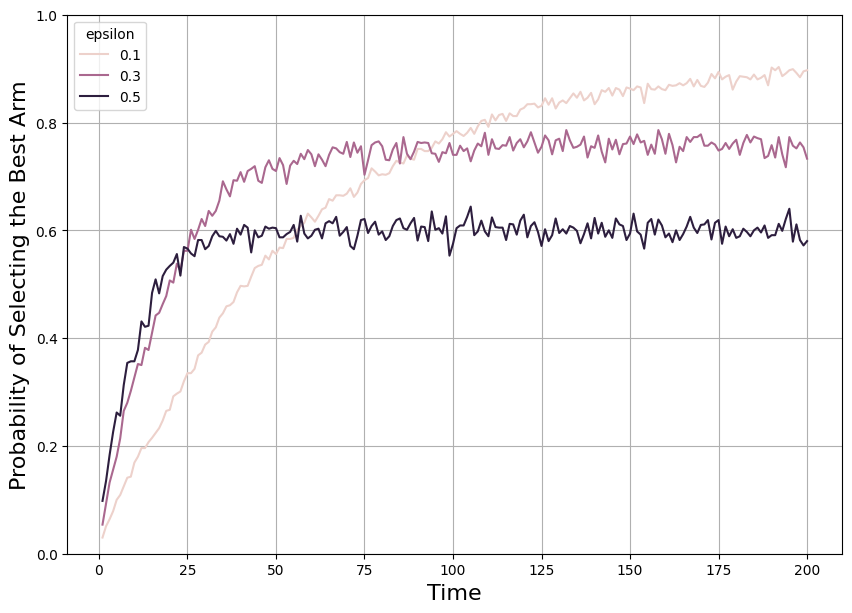

In [ ]:
# Plot
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 7))

sns.lineplot(data = grouped_res,
             x = "times",
             y = "chose_correct",
             hue = "epsilon",
             ax = ax)

ax.set_ylabel("Probability of Selecting the Best Arm", fontsize = 16)
ax.set_xlabel("Time", fontsize = 16)
ax.set_ylim(0, 1)

plt.grid()
plt.show()

In [ ]:
# Create the function
def plot_correct_proba(results, best_arms):
    # Copy results
    res = results[["epsilon", "times", "chosen_arm"]].copy()

    # Wrangling data
    res["chose_correct"] = (res["chosen_arm"] == best_arms).astype("int")
    filtered_res = res[["epsilon", "times", "chose_correct"]]
    grouped_res = filtered_res.groupby(["epsilon", "times"]).agg("mean")

    # Plot
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 7))

    sns.lineplot(data = grouped_res,
                 x = "times",
                 y = "chose_correct",
                 hue = "epsilon",
                 ax = ax)

    ax.set_ylabel("Probability of Selecting the Best Arm", fontsize = 16)
    ax.set_xlabel("Time", fontsize = 16)
    ax.set_ylim(0, 1)

    plt.grid()
    plt.show()


- Epsilon affects
    - the length of time to converge
    - the maximum value of probability of selecting the best arm
<br><br>
- The bigger the epsilon is, more exploration, smaller probability of selecting the best arm, vice versa.

**QUESTION**

1. If you have a long term experimentation, which epsilon should you choose?
2. If you need to optimize the flash-sale (say 5 day sales), which epsilon should you choose?

### **2. Generated Reward & Regret**
---

#### **Expected Reward & Regret**

- We can calculate the **expected** reward and regret by averaging the generated reward & regret over simulations.
- Let's wrangling the data

In [ ]:
# First, filter the needed data
res = results[["epsilon", "times", "reward"]].copy()
res

,epsilon,times,reward
0,0.1,1,0.0
1,0.1,2,0.0
2,0.1,3,0.0
3,0.1,4,0.0
4,0.1,5,0.0
...,...,...,...
199995,0.5,196,0.0
199996,0.5,197,0.0
199997,0.5,198,1.0
199998,0.5,199,0.0


In [ ]:
# Group the results
grouped_res = res.groupby(["epsilon", "times"]).agg("mean")
grouped_res = grouped_res.reset_index()
grouped_res

,epsilon,times,reward
0,0.1,1,0.120
1,0.1,2,0.154
2,0.1,3,0.146
3,0.1,4,0.174
4,0.1,5,0.177
...,...,...,...
595,0.5,196,0.572
596,0.5,197,0.588
597,0.5,198,0.566
598,0.5,199,0.570


In [ ]:
# Calculate the optimum average reward ==> variant with maximum cvr
grouped_res["opt_reward"] = np.max(true_cvr)

# Calculate regret
grouped_res["regret"] = grouped_res["opt_reward"] - grouped_res["reward"]

grouped_res

,epsilon,times,reward,opt_reward,regret
0,0.1,1,0.120,0.9,0.780
1,0.1,2,0.154,0.9,0.746
2,0.1,3,0.146,0.9,0.754
3,0.1,4,0.174,0.9,0.726
4,0.1,5,0.177,0.9,0.723
...,...,...,...,...,...
595,0.5,196,0.572,0.9,0.328
596,0.5,197,0.588,0.9,0.312
597,0.5,198,0.566,0.9,0.334
598,0.5,199,0.570,0.9,0.330


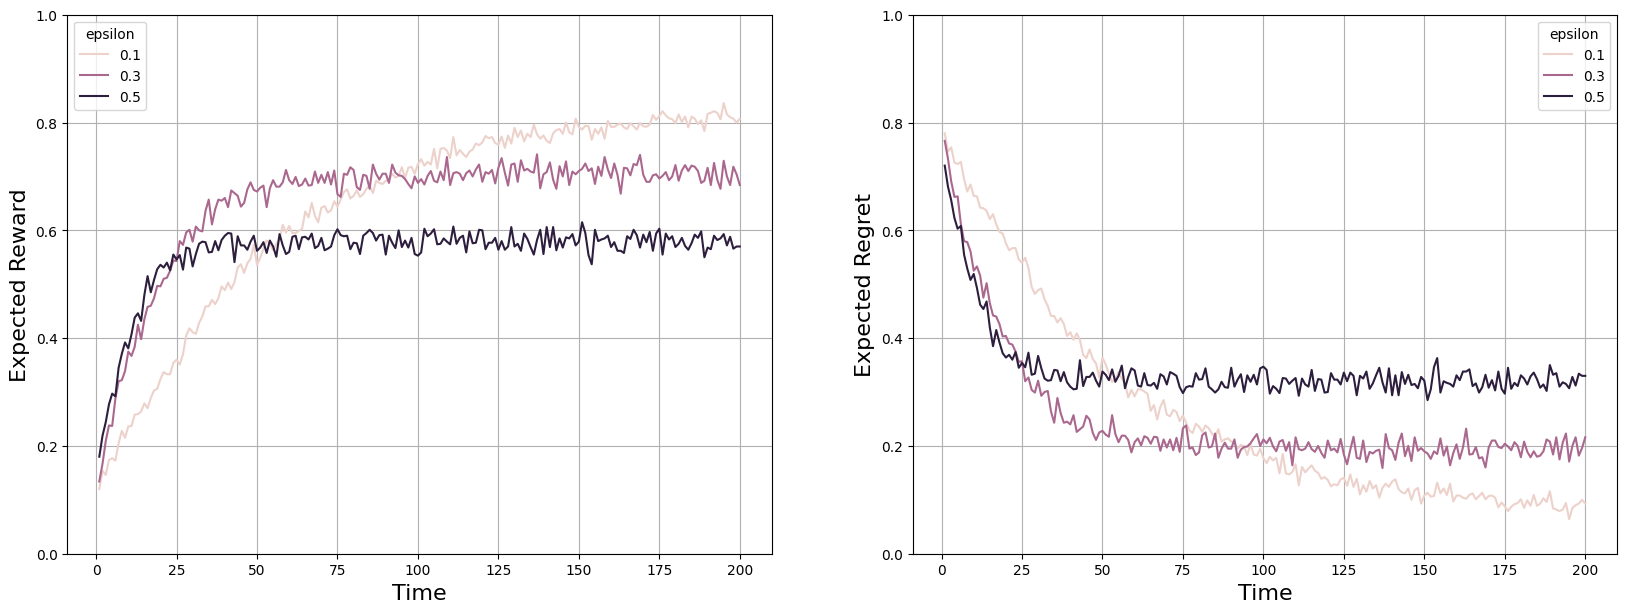

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 7))

# Plot the reward
sns.lineplot(data = grouped_res,
             x = "times",
             y = "reward",
             hue = "epsilon",
             ax = ax[0])

ax[0].set_ylabel("Expected Reward", fontsize = 16)
ax[0].set_xlabel("Time", fontsize = 16)
ax[0].set_ylim(0, 1)
ax[0].grid()

# Plot the regret
sns.lineplot(data = grouped_res,
             x = "times",
             y = "regret",
             hue = "epsilon",
             ax = ax[1])

ax[1].set_ylabel("Expected Regret", fontsize = 16)
ax[1].set_xlabel("Time", fontsize = 16)
ax[1].set_ylim(0, 1)
ax[1].grid()

plt.show()

In [ ]:
def plot_reward_regret(results, best_cvr):
    # First, filter the needed data
    res = results[["epsilon", "times", "reward"]].copy()

    # Group the results
    grouped_res = res.groupby(["epsilon", "times"]).agg("mean")
    grouped_res = grouped_res.reset_index()

    # Calculate the optimum average reward ==> variant with maximum cvr
    grouped_res["opt_reward"] = best_cvr

    # Calculate regret
    grouped_res["regret"] = grouped_res["opt_reward"] - grouped_res["reward"]

    # Finally, plot the results
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 7))

    # Plot the reward
    sns.lineplot(data = grouped_res,
                x = "times",
                y = "reward",
                hue = "epsilon",
                ax = ax[0])

    ax[0].set_ylabel("Expected Reward", fontsize = 16)
    ax[0].set_xlabel("Time", fontsize = 16)
    ax[0].set_ylim(0, 1)
    ax[0].grid()

    # Plot the regret
    sns.lineplot(data = grouped_res,
                x = "times",
                y = "regret",
                hue = "epsilon",
                ax = ax[1])

    ax[1].set_ylabel("Expected Regret", fontsize = 16)
    ax[1].set_xlabel("Time", fontsize = 16)
    ax[1].set_ylim(0, 1)
    ax[1].grid()

    plt.show()

- Expected reward (in this case) is similar to the average conversion rate
- The expected reward & regret will converge at some points
- If it is not, there is a chance that your algorithm does not work well.
- Based on the results, epsilon affects
    - the length of time to converge
    - the maximum value of rewards or regret

- Bigger **epsilon** makes **smaller** expected rewards and **bigger** expected regret
- It is obvious, because **bigger** epsilon means more exploration and less exploitation

#### **Expected Cumulative Reward & Regret**

- How about the cumulative reward & regret?
- What will happen to them during the experimentation?
- Will they go up, go down, or converge?
- Let's wrangling the data to find it out!

In [ ]:
# Filter the needed data
res = results[["epsilon", "times", "cum_reward"]].copy()
res

,epsilon,times,cum_reward
0,0.1,1,0.0
1,0.1,2,0.0
2,0.1,3,0.0
3,0.1,4,0.0
4,0.1,5,0.0
...,...,...,...
199995,0.5,196,103.0
199996,0.5,197,103.0
199997,0.5,198,104.0
199998,0.5,199,104.0


In [ ]:
# Group the data to find average cumulative reward
grouped_res = res.groupby(["epsilon", "times"]).agg("mean")
grouped_res = grouped_res.reset_index()
grouped_res

,epsilon,times,cum_reward
0,0.1,1,0.120
1,0.1,2,0.274
2,0.1,3,0.420
3,0.1,4,0.594
4,0.1,5,0.771
...,...,...,...
595,0.5,196,109.312
596,0.5,197,109.900
597,0.5,198,110.466
598,0.5,199,111.036


In [ ]:
# Calculate the optimum cumulative reward (from the best cvr)
grouped_res["opt_cum_reward"] = grouped_res["times"] * np.max(true_cvr)

# Calculate the cumulative regret
grouped_res["cum_regret"] = grouped_res["opt_cum_reward"] - grouped_res["cum_reward"]

grouped_res

,epsilon,times,cum_reward,opt_cum_reward,cum_regret
0,0.1,1,0.120,0.9,0.780
1,0.1,2,0.274,1.8,1.526
2,0.1,3,0.420,2.7,2.280
3,0.1,4,0.594,3.6,3.006
4,0.1,5,0.771,4.5,3.729
...,...,...,...,...,...
595,0.5,196,109.312,176.4,67.088
596,0.5,197,109.900,177.3,67.400
597,0.5,198,110.466,178.2,67.734
598,0.5,199,111.036,179.1,68.064


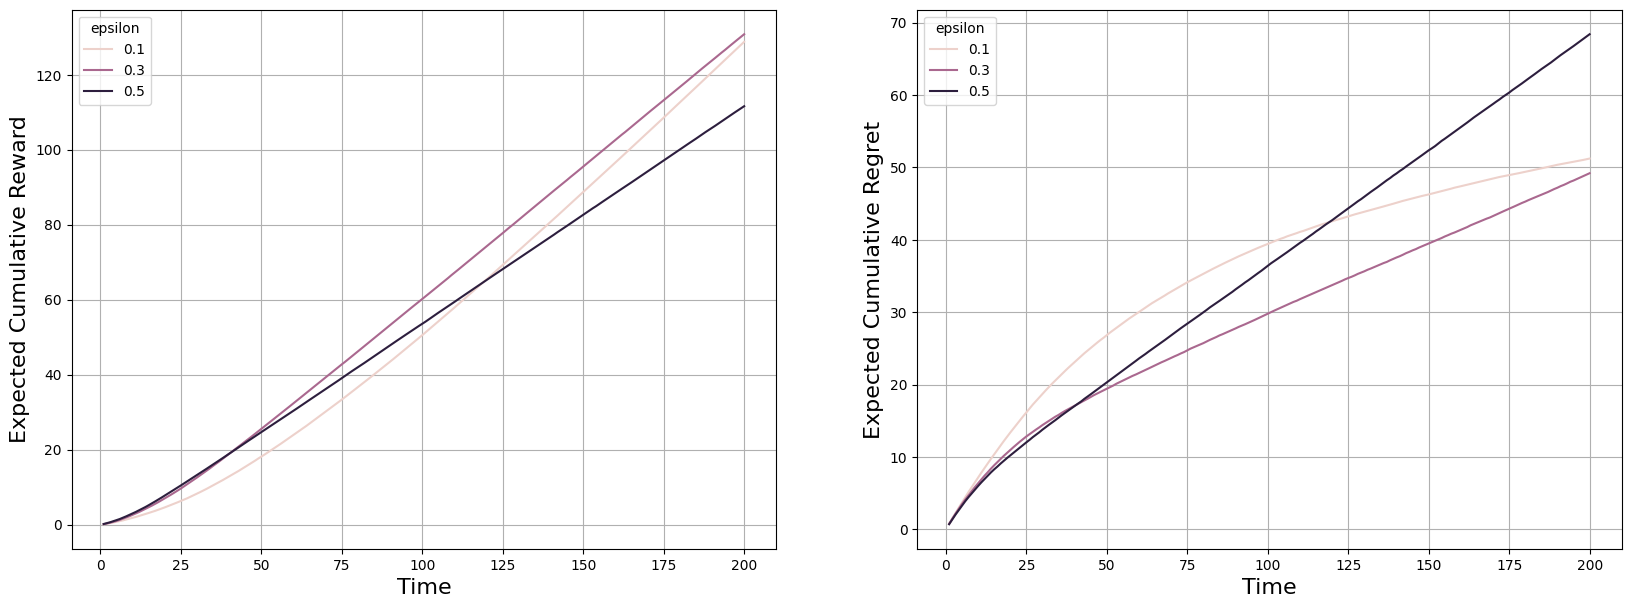

In [ ]:
# Plot
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 7))

# Plot the reward
sns.lineplot(data = grouped_res,
             x = "times",
             y = "cum_reward",
             hue = "epsilon",
             ax = ax[0])

ax[0].set_ylabel("Expected Cumulative Reward", fontsize = 16)
ax[0].set_xlabel("Time", fontsize = 16)
ax[0].grid()

# Plot the regret
sns.lineplot(data = grouped_res,
             x = "times",
             y = "cum_regret",
             hue = "epsilon",
             ax = ax[1])

ax[1].set_ylabel("Expected Cumulative Regret", fontsize = 16)
ax[1].set_xlabel("Time", fontsize = 16)
ax[1].grid()

plt.show()

In [ ]:
def plot_cum_reward_regret(results, best_cvr):
    # Filter the needed data
    res = results[["epsilon", "times", "cum_reward"]].copy()

    # Group the data to find average cumulative reward
    grouped_res = res.groupby(["epsilon", "times"]).agg("mean")
    grouped_res = grouped_res.reset_index()

    # Calculate the optimum cumulative reward (from the best cvr)
    grouped_res["opt_cum_reward"] = grouped_res["times"] * best_cvr

    # Calculate the cumulative regret
    grouped_res["cum_regret"] = grouped_res["opt_cum_reward"] - grouped_res["cum_reward"]

    # Plot
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 7))

    # Plot the reward
    sns.lineplot(data = grouped_res,
                x = "times",
                y = "cum_reward",
                hue = "epsilon",
                ax = ax[0])

    ax[0].set_ylabel("Expected Cumulative Reward", fontsize = 16)
    ax[0].set_xlabel("Time", fontsize = 16)
    ax[0].grid()

    # Plot the regret
    sns.lineplot(data = grouped_res,
                x = "times",
                y = "cum_regret",
                hue = "epsilon",
                ax = ax[1])

    ax[1].set_ylabel("Expected Cumulative Regret", fontsize = 16)
    ax[1].set_xlabel("Time", fontsize = 16)
    ax[1].grid()

    plt.show()

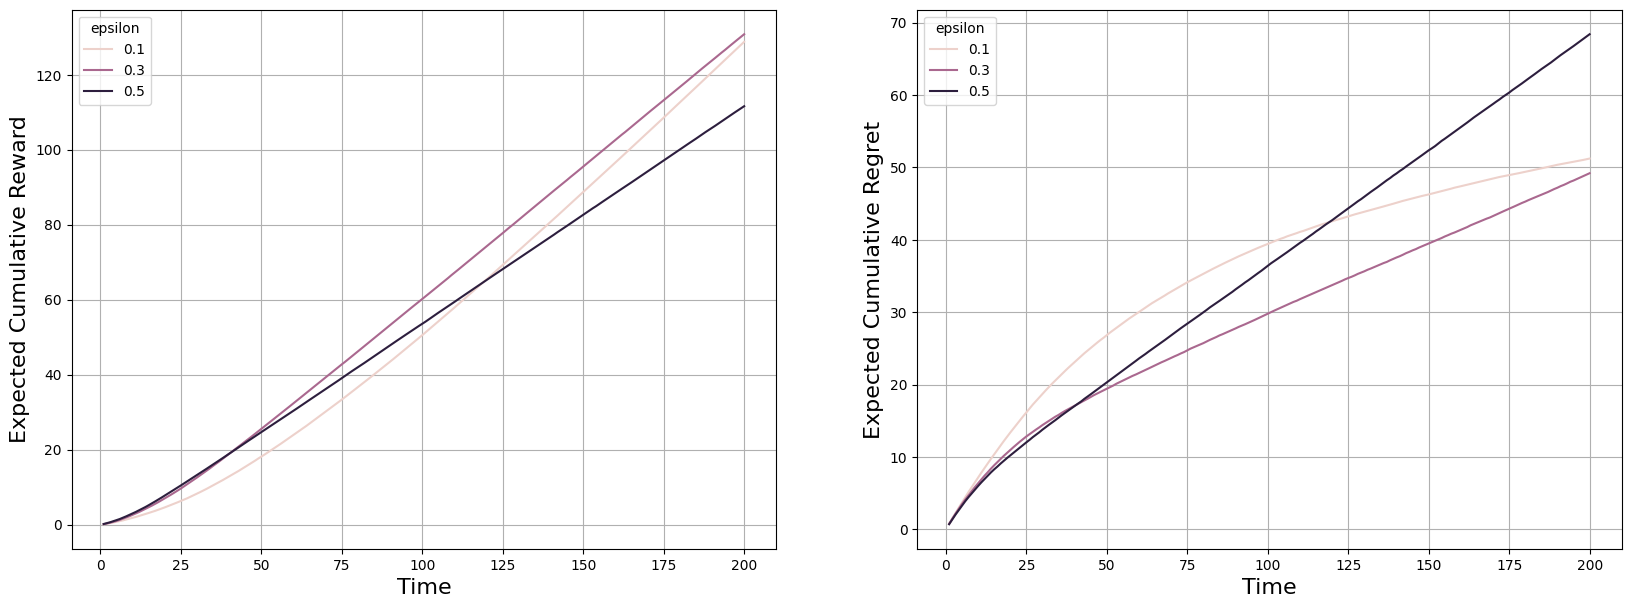

In [ ]:
plot_cum_reward_regret(results = results,
                       best_cvr = np.max(true_cvr))

- The expected cumulative reward & regret do not converge, but linearly increase
- Why? Because the expected reward & regret is not zero, so every time an action is generated, it is expected to increase the reward & regret.
- But we see the slope is different depends on epsilon.
- So, epsilon affects:
    - slope of cumulative reward and regret

### **3. View Traffic Allocations**
---

- **Ideally**, the Bandit algorithm allocates more traffic to the better performing arms
- Thus, we need to see that the traffic proportion of better performing arms is bigger than other arms.
- Let's wrangling the data!

In [ ]:
# Filter the needed data
res = results[["epsilon", "times", "chosen_arm"]].copy()
res

,epsilon,times,chosen_arm
0,0.1,1,0
1,0.1,2,0
2,0.1,3,2
3,0.1,4,0
4,0.1,5,0
...,...,...,...
199995,0.5,196,2
199996,0.5,197,1
199997,0.5,198,4
199998,0.5,199,1


In [ ]:
# Get OHE of the chosen_arm
OHE_arm = pd.get_dummies(res["chosen_arm"])
OHE_arm

,0,1,2,3,4
0,True,False,False,False,False
1,True,False,False,False,False
2,False,False,True,False,False
3,True,False,False,False,False
4,True,False,False,False,False
...,...,...,...,...,...
199995,False,False,True,False,False
199996,False,True,False,False,False
199997,False,False,False,False,True
199998,False,True,False,False,False


In [ ]:
# Concat the OHE_arm to res
res = pd.concat((res, OHE_arm), axis=1)

# Drop the chosen arm
res = res.drop(columns = ["chosen_arm"])

res

,epsilon,times,0,1,2,3,4
0,0.1,1,True,False,False,False,False
1,0.1,2,True,False,False,False,False
2,0.1,3,False,False,True,False,False
3,0.1,4,True,False,False,False,False
4,0.1,5,True,False,False,False,False
...,...,...,...,...,...,...,...
199995,0.5,196,False,False,True,False,False
199996,0.5,197,False,True,False,False,False
199997,0.5,198,False,False,False,False,True
199998,0.5,199,False,True,False,False,False


In [ ]:
# Groupby the results to get the proportion
grouped_res = res.groupby(["epsilon", "times"]).agg("mean")
grouped_res = grouped_res.reset_index()
grouped_res

,epsilon,times,0,1,2,3,4
0,0.1,1,0.906,0.021,0.023,0.020,0.030
1,0.1,2,0.888,0.014,0.021,0.026,0.051
2,0.1,3,0.867,0.022,0.028,0.019,0.064
3,0.1,4,0.851,0.023,0.028,0.019,0.079
4,0.1,5,0.818,0.024,0.036,0.022,0.100
...,...,...,...,...,...,...,...
595,0.5,196,0.096,0.106,0.114,0.105,0.579
596,0.5,197,0.102,0.096,0.100,0.091,0.611
597,0.5,198,0.091,0.114,0.112,0.101,0.582
598,0.5,199,0.117,0.113,0.110,0.088,0.572


In [ ]:
filtered_res = grouped_res[grouped_res["epsilon"] == 0.1]
filtered_res = filtered_res.drop(columns = ["epsilon", "times"])
filtered_res

,0,1,2,3,4
0,0.906,0.021,0.023,0.020,0.030
1,0.888,0.014,0.021,0.026,0.051
2,0.867,0.022,0.028,0.019,0.064
3,0.851,0.023,0.028,0.019,0.079
4,0.818,0.024,0.036,0.022,0.100
...,...,...,...,...,...
195,0.028,0.021,0.022,0.030,0.899
196,0.031,0.030,0.026,0.021,0.892
197,0.040,0.024,0.026,0.026,0.884
198,0.032,0.022,0.025,0.026,0.895


In [ ]:
horizons = [t+1 for t in range(len(filtered_res))]
proportions = filtered_res.values.T

print(horizon)
print(proportions)

200
[[0.906 0.888 0.867 0.851 0.818 0.806 0.787 0.77  0.755 0.731 0.714 0.713
  0.696 0.686 0.663 0.657 0.635 0.624 0.612 0.602 0.601 0.577 0.556 0.546
  0.552 0.55  0.536 0.507 0.489 0.487 0.468 0.451 0.436 0.419 0.421 0.41
  0.394 0.386 0.375 0.37  0.365 0.35  0.353 0.326 0.324 0.307 0.314 0.309
  0.294 0.308 0.292 0.278 0.273 0.273 0.268 0.265 0.258 0.253 0.246 0.249
  0.259 0.252 0.239 0.242 0.221 0.232 0.212 0.215 0.214 0.219 0.208 0.222
  0.213 0.204 0.198 0.193 0.181 0.187 0.183 0.181 0.184 0.181 0.172 0.17
  0.172 0.166 0.165 0.145 0.167 0.152 0.147 0.13  0.148 0.138 0.129 0.141
  0.128 0.13  0.132 0.12  0.118 0.115 0.121 0.119 0.112 0.114 0.113 0.1
  0.098 0.106 0.106 0.109 0.097 0.095 0.1   0.092 0.093 0.093 0.082 0.082
  0.084 0.085 0.075 0.073 0.082 0.065 0.075 0.071 0.072 0.074 0.073 0.07
  0.066 0.061 0.069 0.064 0.064 0.071 0.061 0.062 0.058 0.062 0.054 0.058
  0.057 0.051 0.054 0.06  0.055 0.051 0.055 0.05  0.057 0.066 0.052 0.056
  0.041 0.045 0.054 0.055 0.053 0.052 0

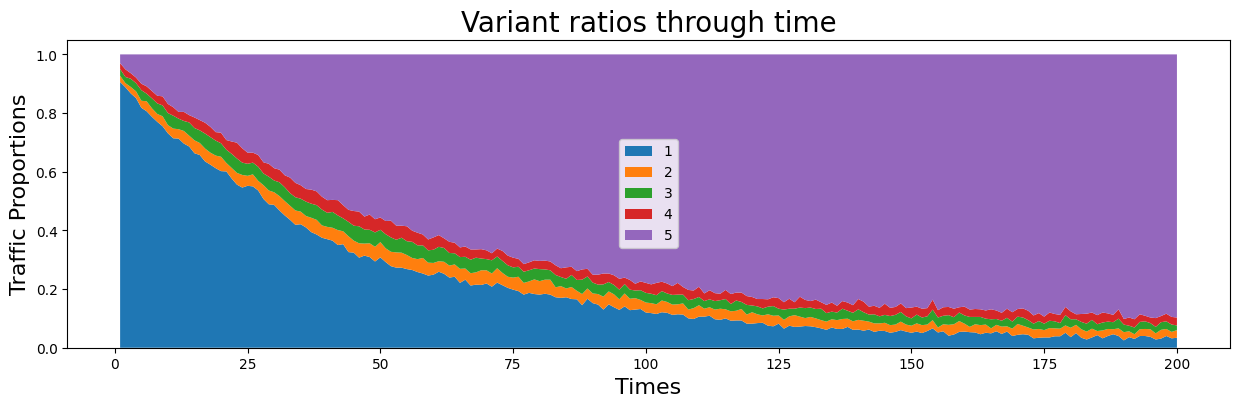

In [ ]:
# Plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 4))

ax.stackplot(horizons, proportions, labels = [f"{i+1}" for i in range(proportions.shape[0])])

plt.title("Variant ratios through time", fontsize=20)

ax.set_xlabel("Times", fontsize=16)
ax.set_ylabel("Traffic Proportions", fontsize=16)
plt.legend()
plt.show()

In [ ]:
def plot_traffic_proportions(results):
    # Filter the needed data
    res = results[["epsilon", "times", "chosen_arm"]].copy()

    # Get OHE of the chosen_arm
    OHE_arm = pd.get_dummies(res["chosen_arm"])

    # Concat the OHE_arm to res
    res = pd.concat((res, OHE_arm), axis=1)

    # Drop the chosen arm
    res = res.drop(columns = ["chosen_arm"])

    # Groupby the results to get the proportion
    grouped_res = res.groupby(["epsilon", "times"]).agg("mean")
    grouped_res = grouped_res.reset_index()

    # Find list of epsilon
    epsilons = sorted(set(grouped_res["epsilon"]))

    # Start plotting
    fig, ax = plt.subplots(nrows=len(epsilons), ncols=1, figsize=(15, 7*len(epsilons)))
    for i, epsilon in enumerate(epsilons):
        # Filter data
        filtered_res = grouped_res[grouped_res["epsilon"] == epsilon]
        filtered_res = filtered_res.drop(columns = ["epsilon", "times"])

        # Create horizon & proportions
        horizons = [t+1 for t in range(len(filtered_res))]
        proportions = filtered_res.values.T

        # Plot
        ax[i].stackplot(horizons,
                        proportions,
                        labels = [f"{i+1}" for i in range(proportions.shape[0])])

        ax[i].set_title(f"Epsilon: {epsilon}", fontsize=20)
        ax[i].set_xlabel("Times", fontsize=16)
        ax[i].set_ylabel("Traffic Proportions", fontsize=16)
        ax[i].legend()

    plt.show()


### **4. Combine all evaluation plot**
---

In [ ]:
def plot_evaluation(results, cvrs):
    # Extract cvr
    best_arms = np.argmax(cvrs)
    best_cvr = np.max(cvrs)

    # 1. Proba of selecting the best
    plot_correct_proba(results = results,
                       best_arms = best_arms)

    # 2. Reward & regret
    plot_reward_regret(results = results,
                       best_cvr = best_cvr)

    # 3. Cumulative reward & regret
    plot_cum_reward_regret(results = results,
                           best_cvr = best_cvr)

    # 4. Traffic allocation
    plot_traffic_proportions(results = results)


# <font color='blue'>5. Case Study</font>
---

In [ ]:
# Define some variables
cvr_case_1 = [0.1, 0.9]
cvr_case_2 = [0.1]*5 + [0.9]
epsilons = [0.1, 0.3, 0.5]
num_sims = 1000
horizon = 200

print(cvr_case_1)
print(cvr_case_2)

[0.1, 0.9]
[0.1, 0.1, 0.1, 0.1, 0.1, 0.9]


In [ ]:
# Do the Monte Carlo simulation
# It will takes some times, better to run it in local
res_1 = epsilon_greedy_mc(cvrs = cvr_case_1,
                          epsilons = epsilons,
                          num_sims = num_sims,
                          horizon = horizon)

res_2 = epsilon_greedy_mc(cvrs = cvr_case_2,
                          epsilons = epsilons,
                          num_sims = num_sims,
                          horizon = horizon)

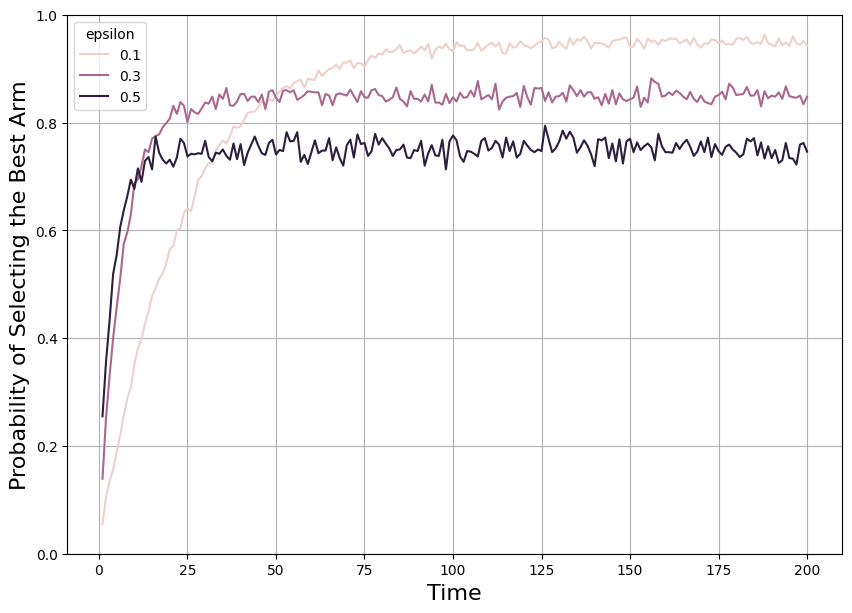

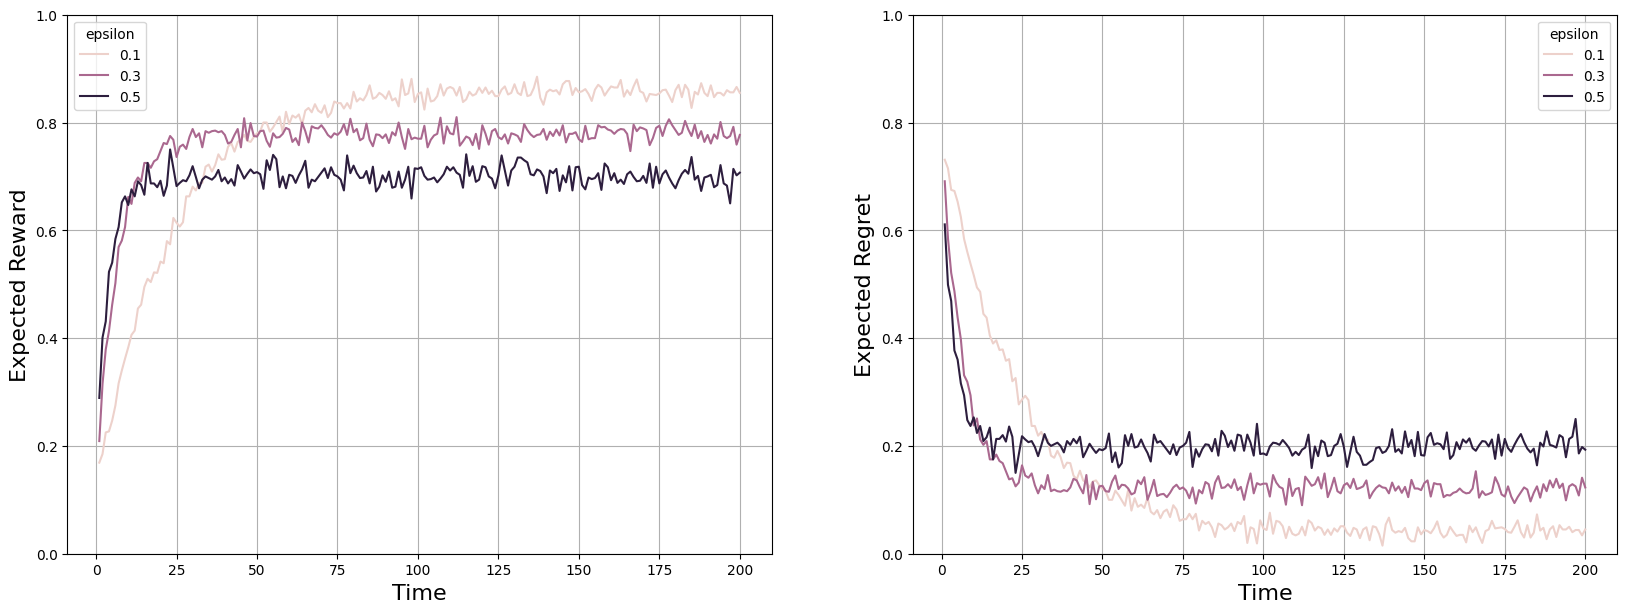

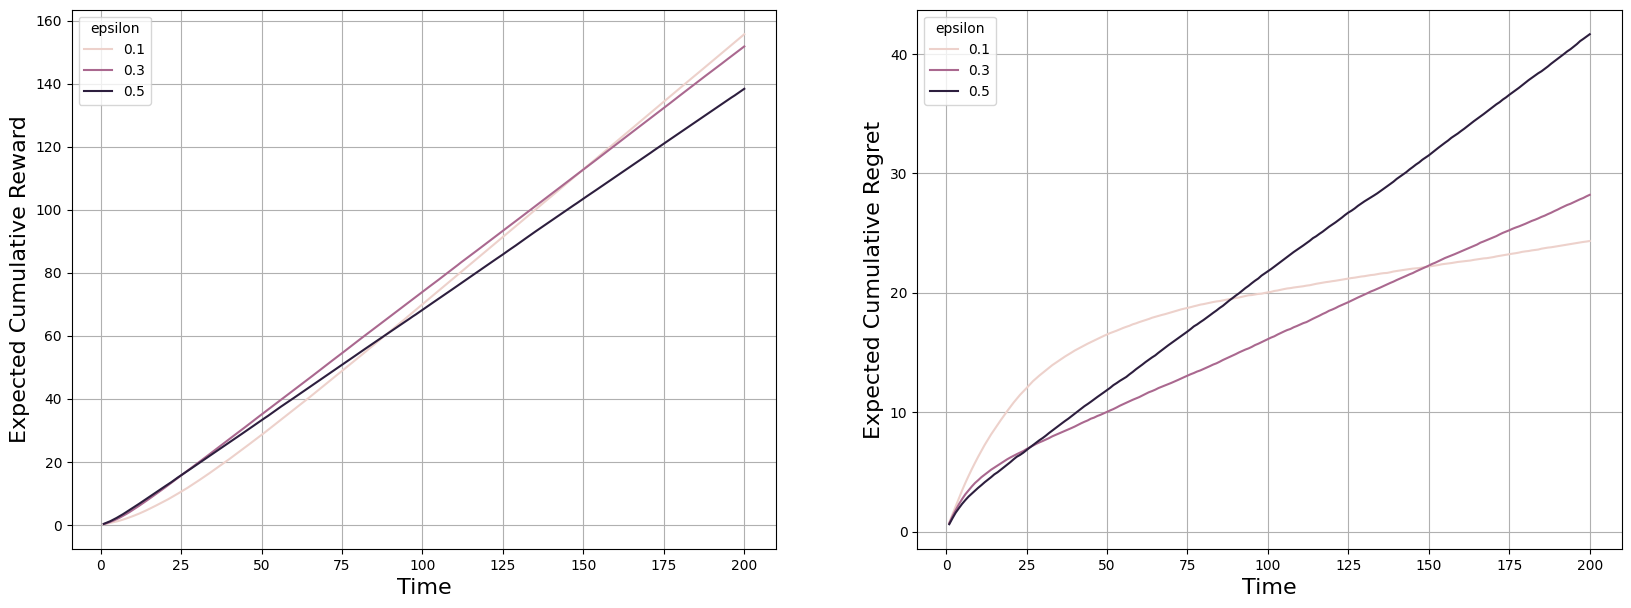

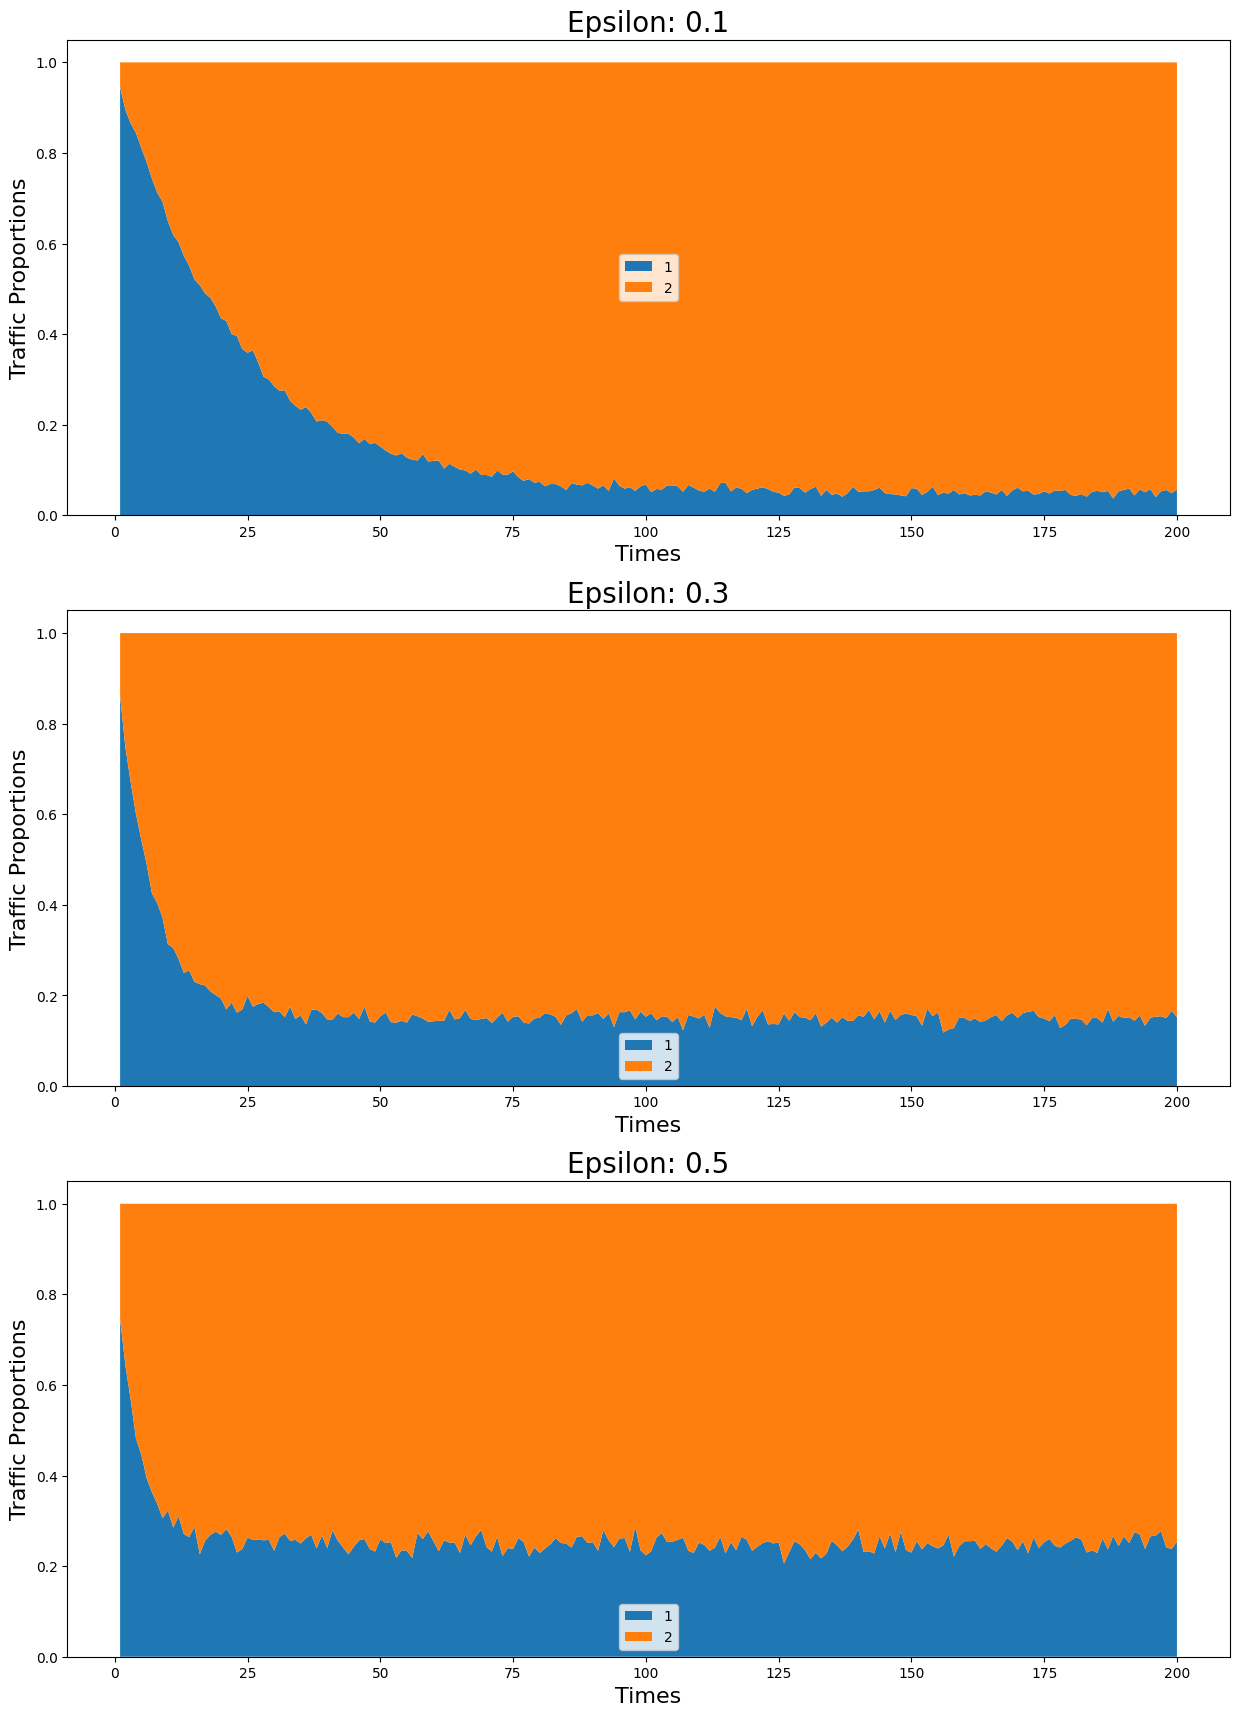

In [ ]:
# Plot the evaluation
plot_evaluation(results = res_1,
                cvrs = cvr_case_1)

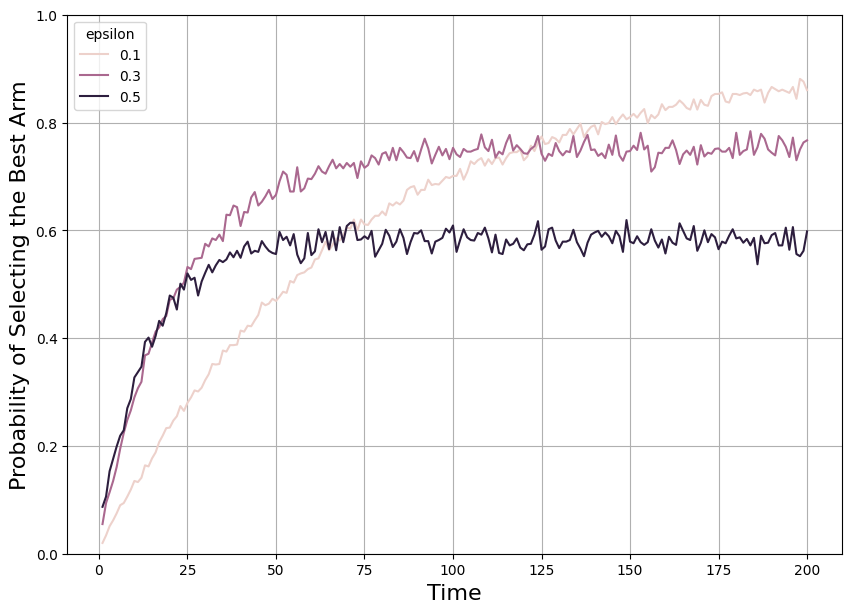

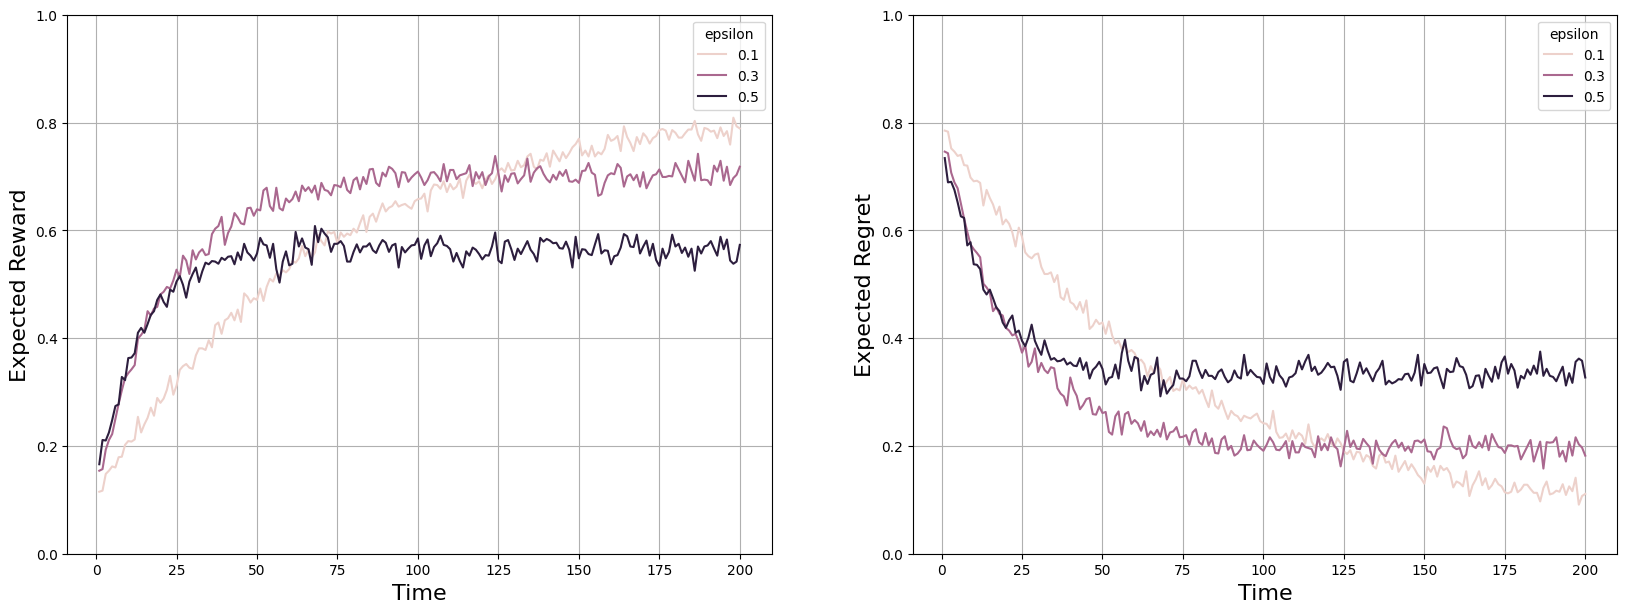

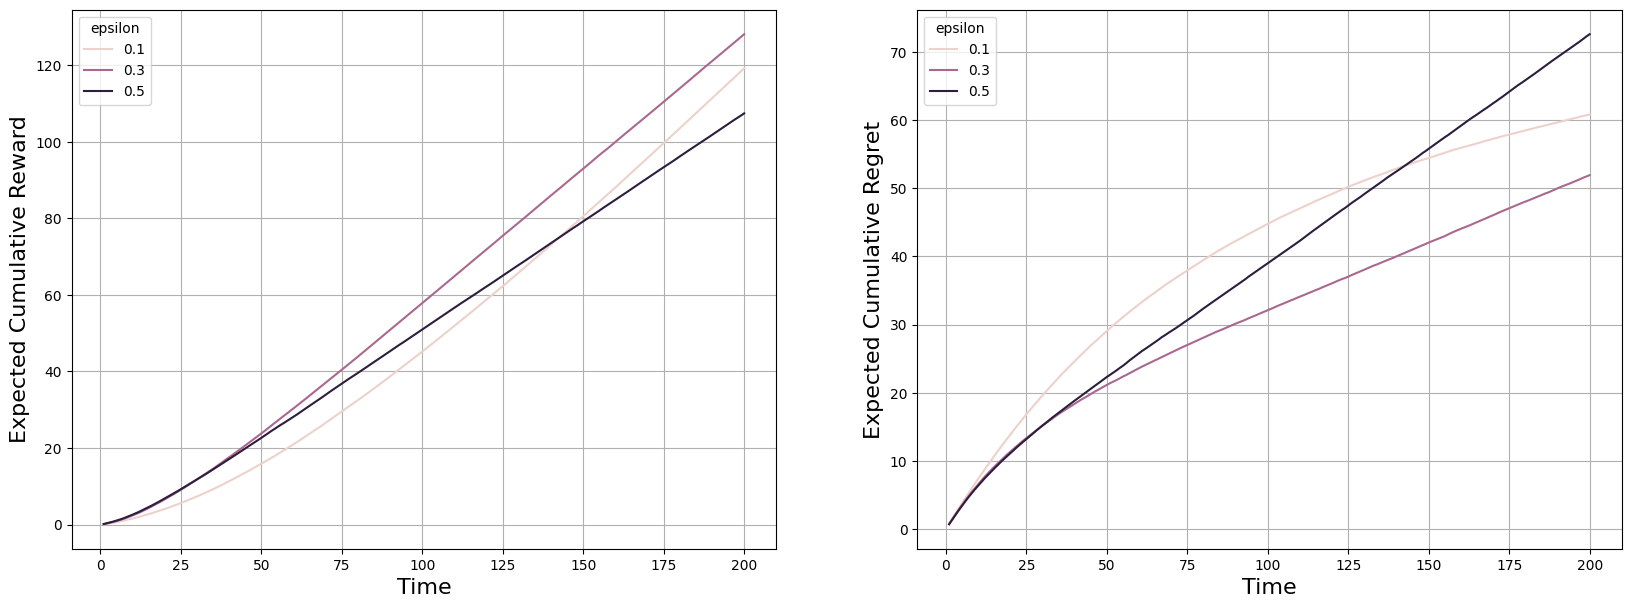

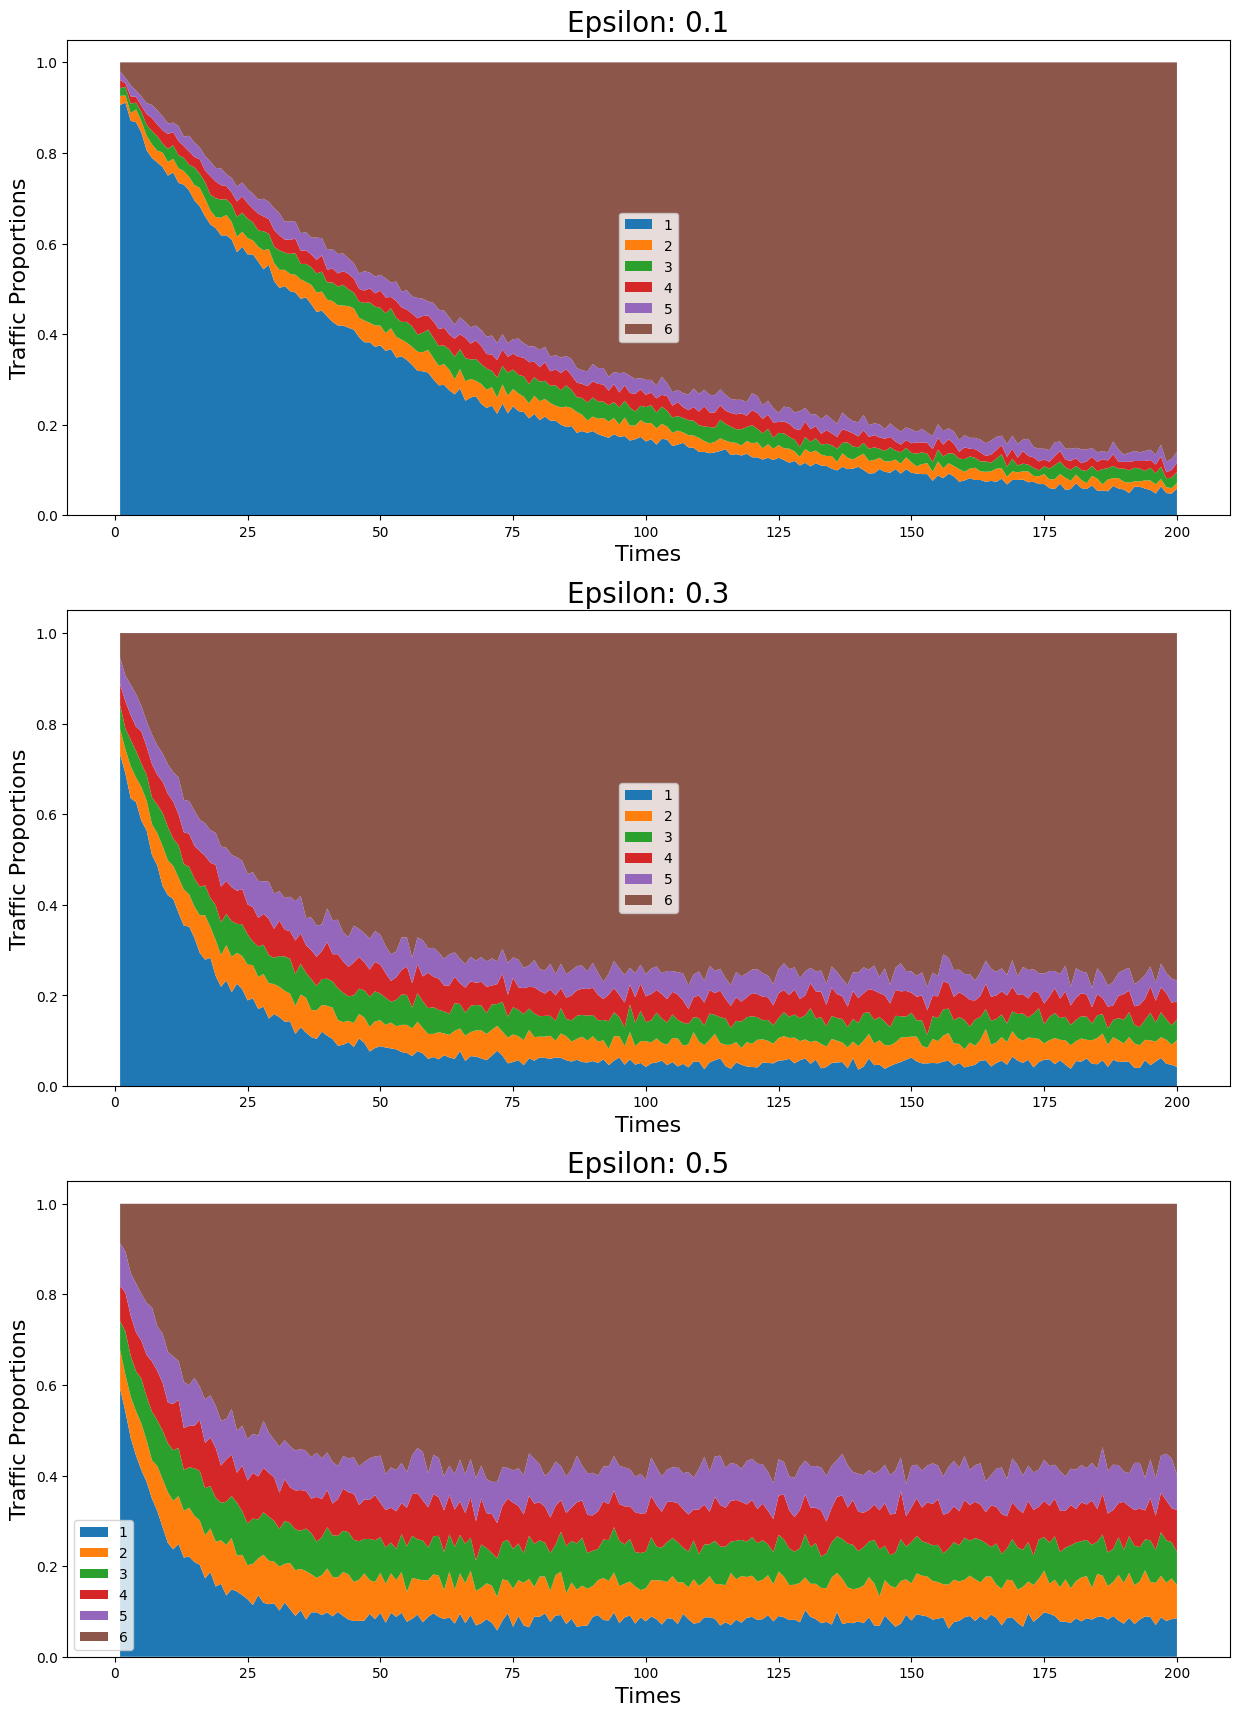

In [ ]:
# Plot the evaluation
plot_evaluation(results = res_2,
                cvrs = cvr_case_2)

**Based on the graphs above**

<center>

||2 arms|20 arms|
|:--|:--|:--|
|Length of times to converge|Need smaller times|Need larger times|
|Probability of selecting the best|Bigger|Smaller|
|Expected average & cumulative reward when converge|Bigger value|Smaller value|
|Expected average & cumulative regret when converge|Smaller value|Bigger value|
|Traffic alocation|More traffic to the best performing arm|Less traffic to the best performing arm|
|Can it find the best performing arm?|Yes|Yes|

</center>

**Summary**
- Bandit Algorithm works well on small and big arms
- The smaller arm will have bigger probability to select the best performing arm - *It's obvious*
- The smaller arm will have bigger reward & smaller regret, because it allocates better & bigger trafic to the best performing arm than the bigger arm.

### **Case - 2: Small vs Big arms difference**
---

**Task**
- Simulate Bandit algortihm with small vs big arms difference.
- Answer the following questions
    - What happen to the length of times to converge?
    - What happen to the generated reward & regret, and their cumulative value?
    - What happen to its traffic proportion?
    - Can Bandit algorithm work well?

**Assumptions**
- The first simulation, use `cvr = [0.1, 0.5, 0.9]` --> big arm difference
- The second simulation, use `cvr = [0.11, 0.12, 0.13]` --> small arm difference
- Simulate the Monte Carlo for 1,000 simulations
- Do 200 horizon

In [ ]:
# Define some variables
cvr_case_3 = [0.1, 0.5, 0.9]
cvr_case_4 = [0.11, 0.12, 0.13]
epsilons = [0.1, 0.3, 0.5]
num_sims = 1000
horizon = 200

print(cvr_case_3)
print(cvr_case_4)

[0.1, 0.5, 0.9]
[0.11, 0.12, 0.13]


In [ ]:
# Do the Monte Carlo simulation
# It will takes some times, better to run it in local
res_3 = epsilon_greedy_mc(cvrs = cvr_case_3,
                          epsilons = epsilons,
                          num_sims = num_sims,
                          horizon = horizon)

res_4 = epsilon_greedy_mc(cvrs = cvr_case_4,
                          epsilons = epsilons,
                          num_sims = num_sims,
                          horizon = horizon)

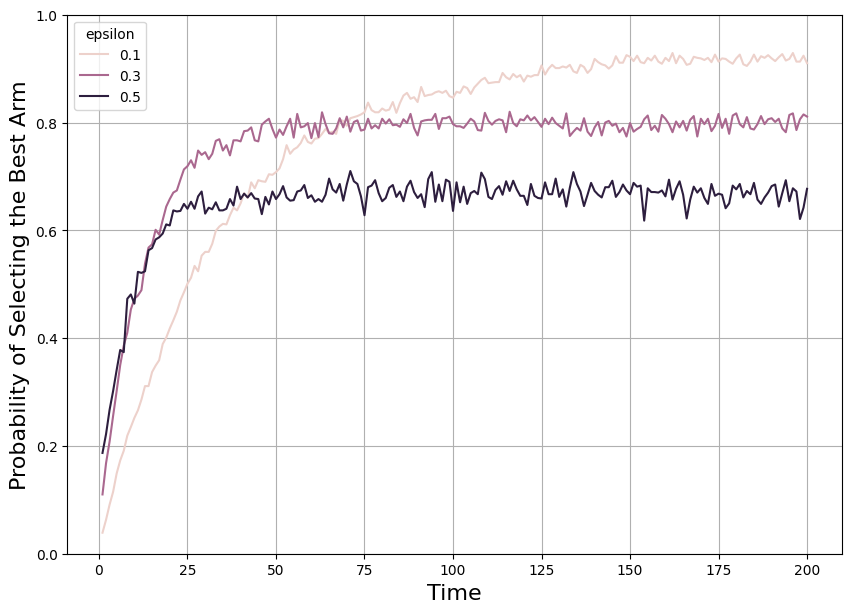

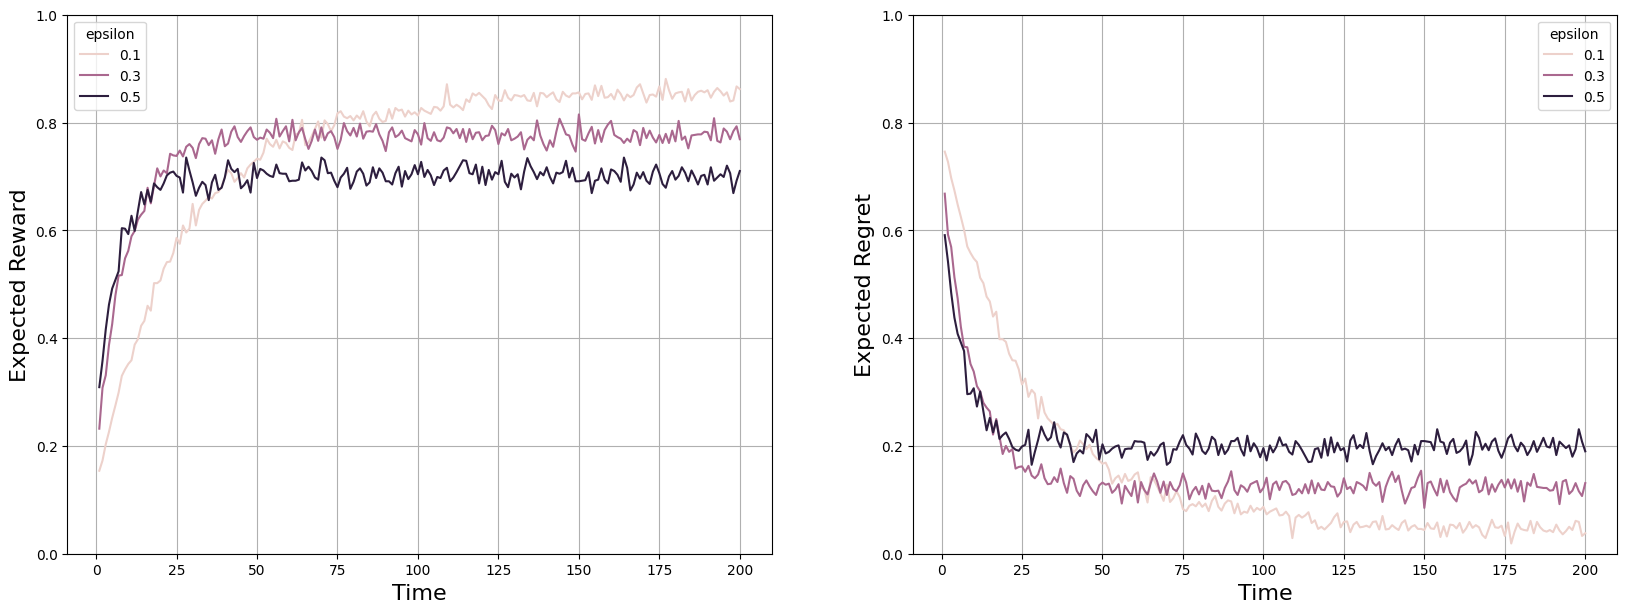

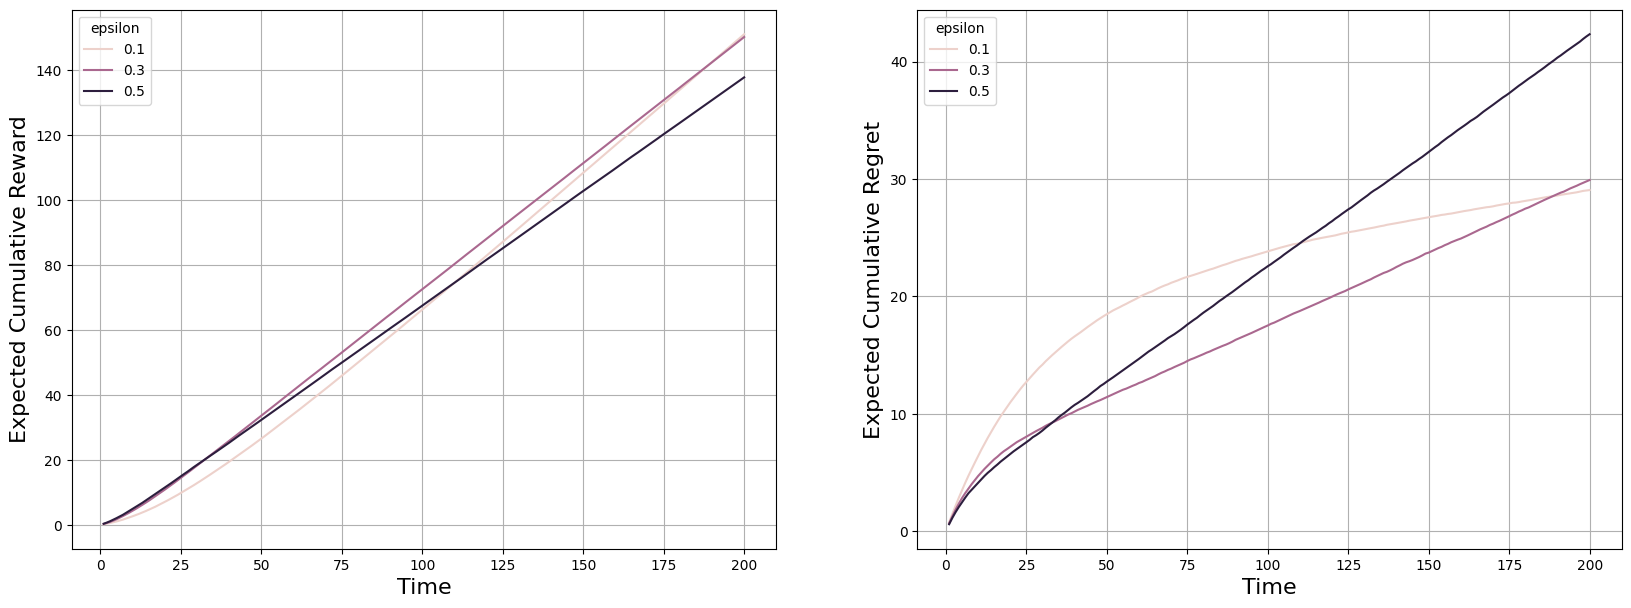

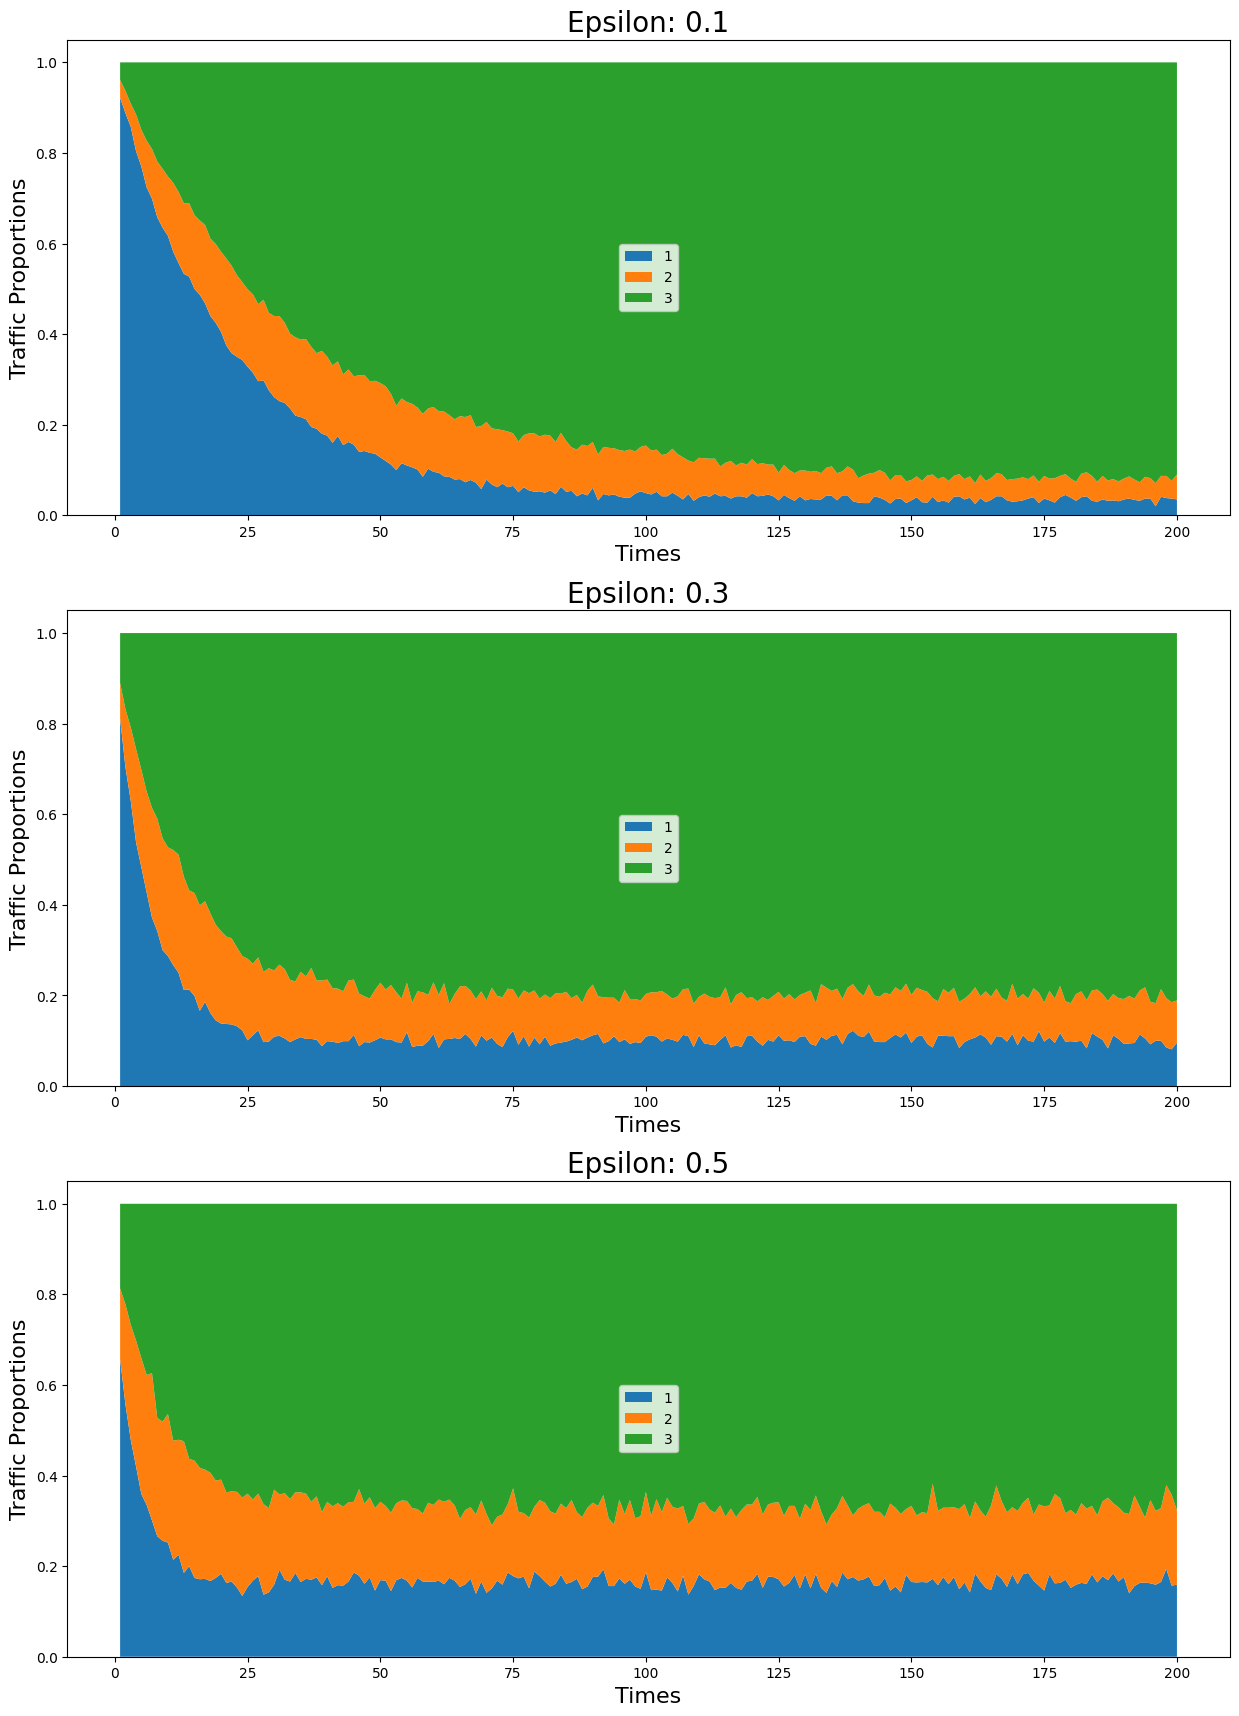

In [ ]:
# Plot the evaluation
plot_evaluation(results = res_3,
                cvrs = cvr_case_3)

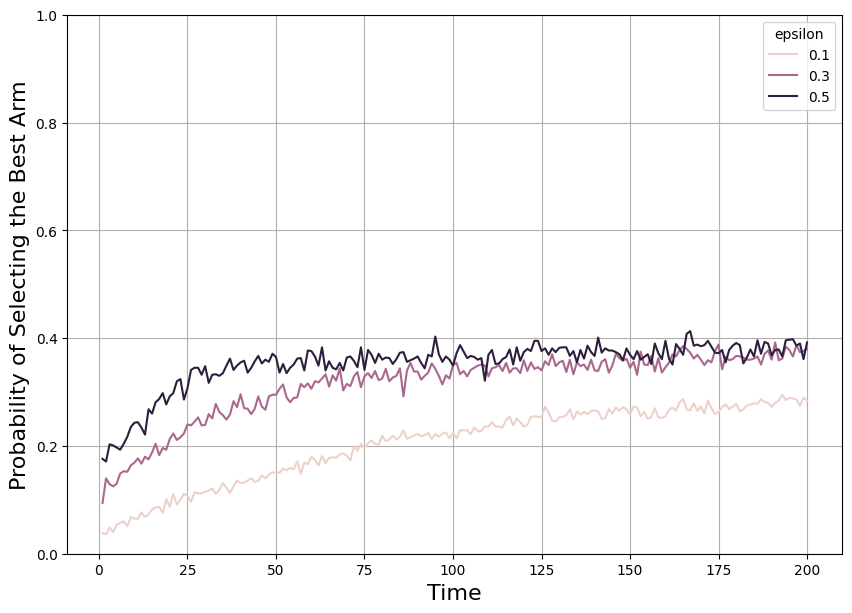

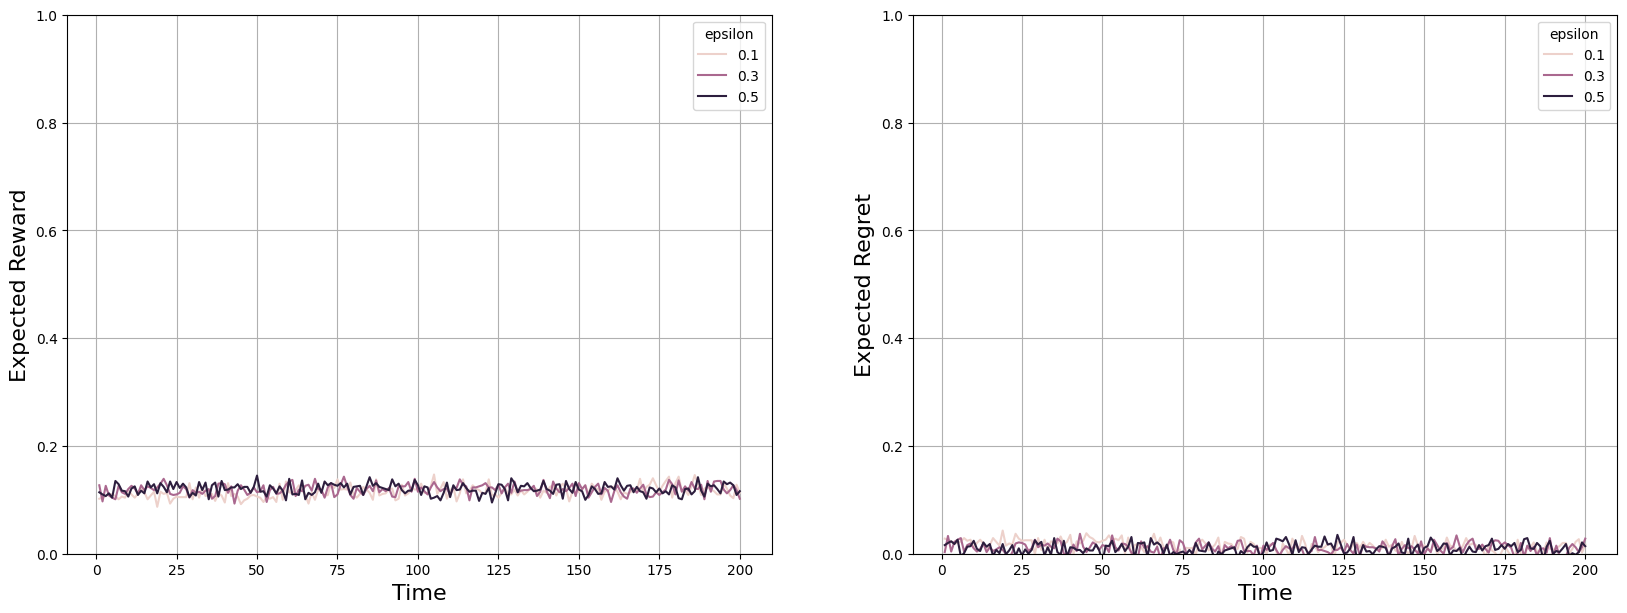

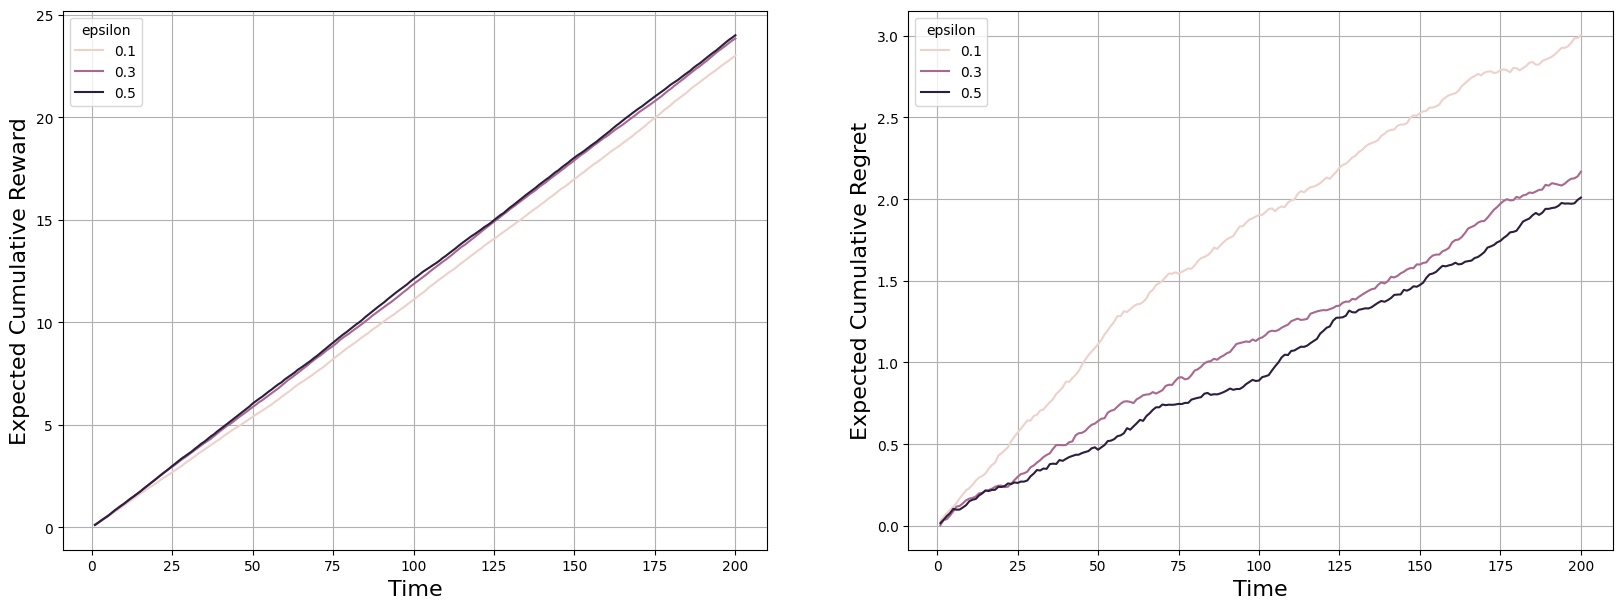

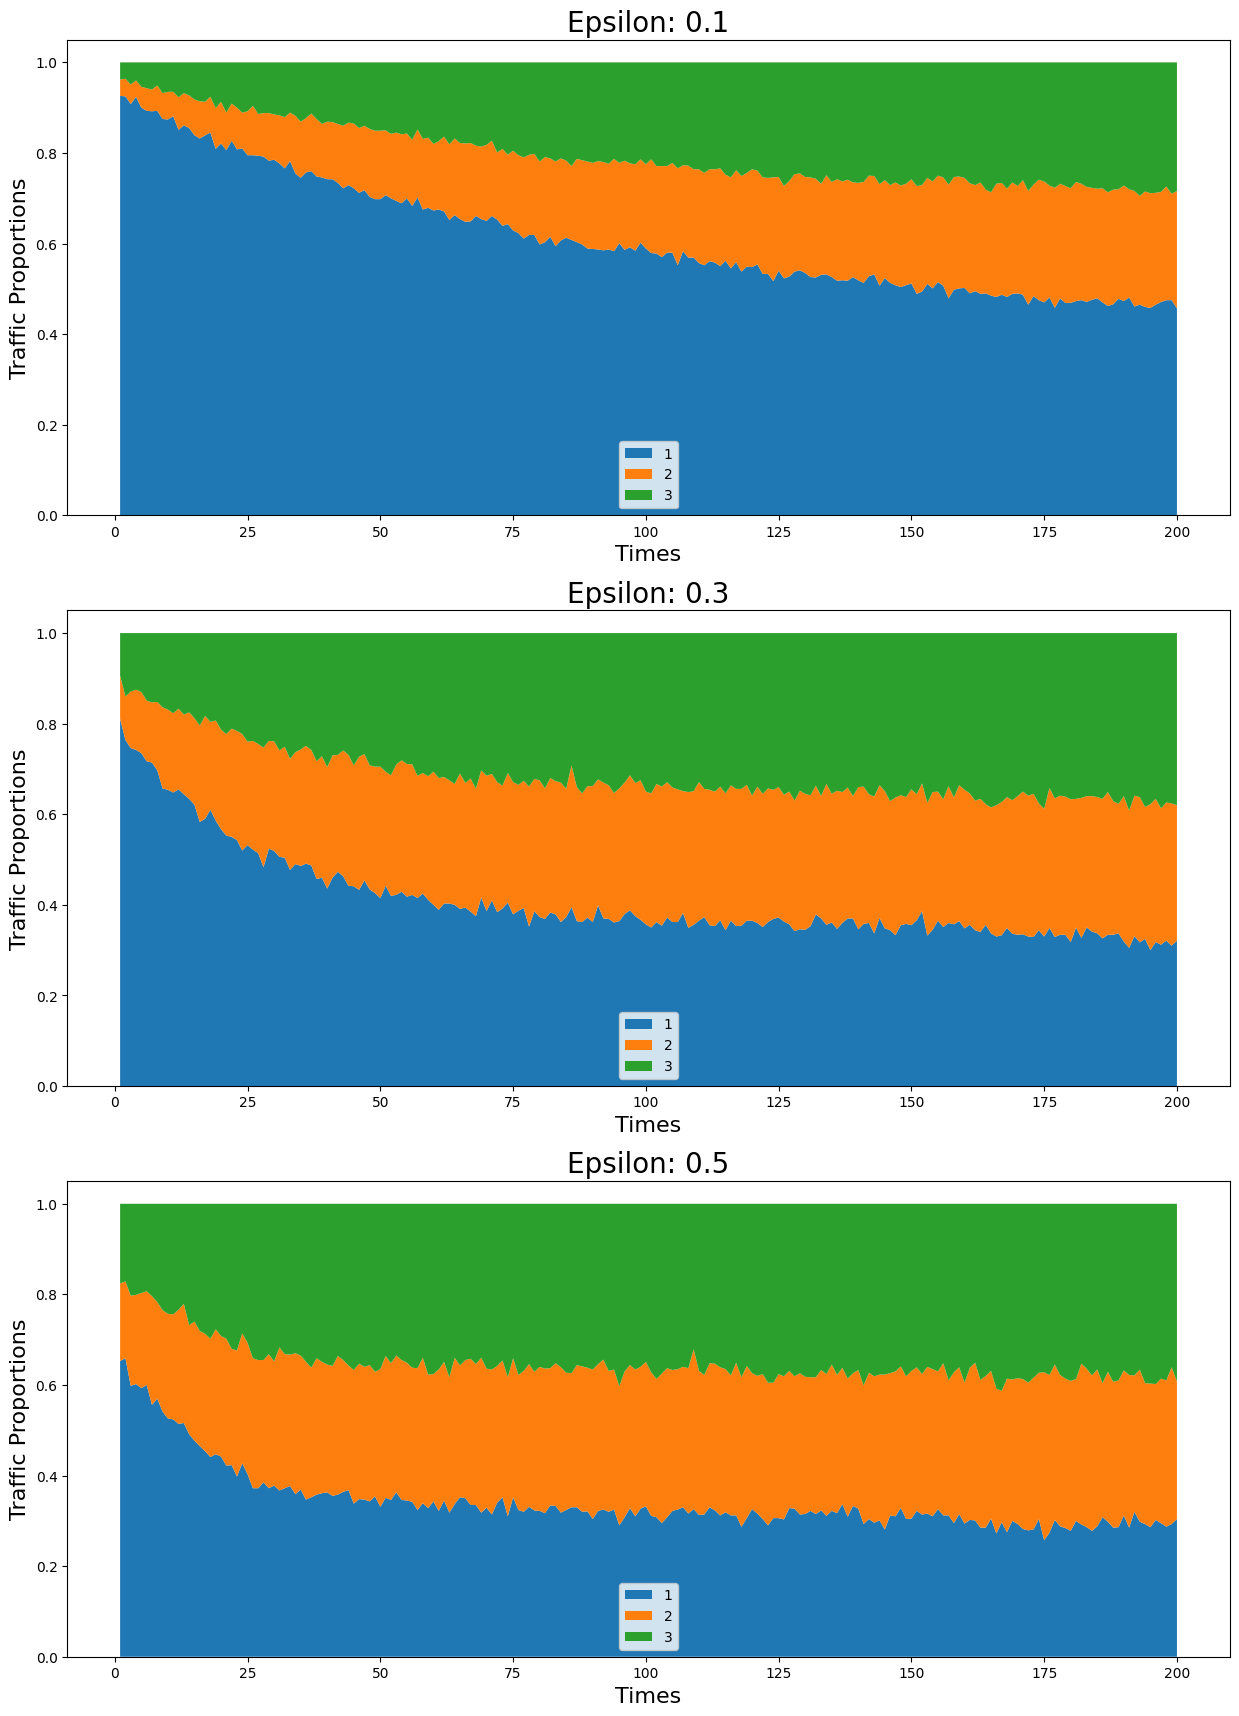

In [ ]:
# Plot the evaluation
plot_evaluation(results = res_4,
                cvrs = cvr_case_4)

**Based on the graphs above**

<center>

||Small difference arms|Big difference arms|
|:--|:--|:--|
|Length of times to converge|Smaller|Bigger|
|Probability of selecting the best|Smaller (around 0.3, slightly better than random choice)|Bigger|
|Expected average & cumulative reward when converge|Smaller value (around 0.15,sligthly better than random choice)|Bigger value|
|Expected average & cumulative regret when converge|Smaller value (can't tell the difference between right & wrong choice)|Bigger value|
|Traffic alocation|Almost similar traffic to each arm|More traffic to the best performing arm|
|Can it find the best performing arm?|Technically yes, but it cannot allocate the traffic better|Yes|

</center>

**Summary**
- The **epsilon-greedy** algorithm have no issue in optimizing arm with clear arm difference
- The **epsilon-greedy** algortihm **cannot** work wells on arms with similar value.
- There have to be an improvement of the algorithm.

## **Work on your own**
- You can work on another algortihm to improve the epsilon-greedy algorithm, such as:
    - Decaying epsilon greedy algorithm
    - Softmax algorithm
    - Upper Confidence Bound (UCB) algorithm